In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import sys
sys.path.append('core')

import argparse
import os
import cv2
import glob
import numpy as np
import torch
from PIL import Image

from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

DEVICE = 'cuda'

In [3]:
path='E:/gopro/GOPRO_Large_all/train/GOPR0374_11_01/'
parser = argparse.ArgumentParser()

parser.add_argument('--model',default='raft-small.pth', help="restore checkpoint")
parser.add_argument('--path',default=path, help="dataset for evaluation")
parser.add_argument('--small', action='store_false', help='use small model')
parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
parser.add_argument('--alternate_corr', action='store_true', help='use efficent correlation implementation')

_StoreTrueAction(option_strings=['--alternate_corr'], dest='alternate_corr', nargs=0, const=True, default=False, type=None, choices=None, help='use efficent correlation implementation', metavar=None)

In [4]:
args = parser.parse_args(args=[])

In [5]:
def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)

## UNet

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

torch.manual_seed(39)
torch.cuda.manual_seed(39)
random.seed(39)
np.random.seed(39)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class SingleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.single_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.single_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [7]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True)

def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=True)

def actFunc(act, *args, **kwargs):
    act = act.lower()
    if act == 'relu':
        return nn.ReLU()
    elif act == 'relu6':
        return nn.ReLU6()
    elif act == 'leakyrelu':
        return nn.LeakyReLU(0.1)
    elif act == 'prelu':
        return nn.PReLU()
    elif act == 'rrelu':
        return nn.RReLU(0.1, 0.3)
    elif act == 'selu':
        return nn.SELU()
    elif act == 'celu':
        return nn.CELU()
    elif act == 'elu':
        return nn.ELU()
    elif act == 'gelu':
        return nn.GELU()
    elif act == 'tanh':
        return nn.Tanh()
    else:
        raise NotImplementedError

In [8]:
# Dense layer
class dense_layer(nn.Module):
    def __init__(self, in_channels, growthRate, activation='gelu'):
        super(dense_layer, self).__init__()
        self.conv = conv3x3(in_channels, growthRate)
        self.act = actFunc(activation)

    def forward(self, x):
        out = self.act(self.conv(x))
        out = torch.cat((x, out), 1)
        return out

# Residual dense block
class RDB(nn.Module):
    def __init__(self, in_channels, growthRate, num_layer, activation='gelu'):
        super(RDB, self).__init__()
        in_channels_ = in_channels
        modules = []
        
        for i in range(num_layer):
            modules.append(dense_layer(in_channels_, growthRate, activation))
            in_channels_ += growthRate
        self.dense_layers = nn.Sequential(*modules)
        self.conv1x1 = conv1x1(in_channels_, in_channels)
        

    def forward(self, x):
        out = self.dense_layers(x)
       
        out = self.conv1x1(out)
        out += x
        return out

# Middle network of residual dense blocks
class RDNet(nn.Module):
    def __init__(self, in_channels, growthRate, num_layer, num_blocks, activation='gelu'):
        super(RDNet, self).__init__()
        self.num_blocks = num_blocks
        self.RDBs = nn.ModuleList()
        for i in range(num_blocks):
            self.RDBs.append(RDB(in_channels, growthRate, num_layer, activation))
        self.conv1x1 = conv1x1(num_blocks * in_channels, in_channels)
        self.conv3x3 = conv3x3(in_channels, in_channels)

    def forward(self, x):
        out = []
        h = x
        for i in range(self.num_blocks):
            h = self.RDBs[i](h)
            out.append(h)
        out = torch.cat(out, dim=1)
        out = self.conv1x1(out)
        out = self.conv3x3(out)
        return out

In [9]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.conv9x9 = nn.Conv2d(3,16, kernel_size=9, stride=1, padding=4, bias =True)
        self.inc = DoubleConv(16, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.refine = RDB(32,16,3)
        self.outc = OutConv(32, n_classes)
        #self.depth_layer = SoftAttnDepth()

    def forward(self, x):
        x = self.conv9x9(x)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.refine(x)
        x = self.outc(x)
        x = F.sigmoid(x)
        #x,pr = self.depth_layer(x)
        return x

In [10]:
x = torch.randn(1, 3, 720, 1280).cuda()

In [11]:
from thop import clever_format
from thop import profile

model=UNet()

input = torch.randn(1, 3, 720, 1280)
flops, params = profile(model, inputs=(input, ))
flops, params = clever_format([flops, params], "%.3f")
print(flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.DoubleConv'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class '__main__.Down'>. Treat it as zero Macs and zero Params.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
[WARN] Cannot find rule for <class '__main__.Up'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.GELU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.dense_layer'>. Treat it as zero Macs and zero Params.
[

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1614: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Data generation

In [14]:
pathlist_train=[]
pathlist_test=[]
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0372_07_00/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0372_07_01/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0374_11_00/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0374_11_01/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0374_11_02/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0374_11_03/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0378_13_00/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0379_11_00/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0380_11_00/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0384_11_01/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0384_11_02/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0384_11_03/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0384_11_04/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0385_11_00/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0386_11_00/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0477_11_00/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0857_11_00/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0868_11_01/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0868_11_02/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0871_11_01/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0881_11_00/')
pathlist_train.append('E:/gopro/BLE_raw_bi_large/train/GOPR0884_11_00/')
pathlist_test.append('E:/gopro/BLE_raw_bi/test/GOPR0384_11_00/')
pathlist_test.append('E:/gopro/BLE_raw_bi/test/GOPR0384_11_05/')
pathlist_test.append('E:/gopro/BLE_raw_bi/test/GOPR0385_11_01/')
pathlist_test.append('E:/gopro/BLE_raw_bi/test/GOPR0396_11_00/')
pathlist_test.append('E:/gopro/BLE_raw_bi/test/GOPR0410_11_00/')
pathlist_test.append('E:/gopro/BLE_raw_bi/test/GOPR0854_11_00/')
pathlist_test.append('E:/gopro/BLE_raw_bi/test/GOPR0862_11_00/')
pathlist_test.append('E:/gopro/BLE_raw_bi/test/GOPR0868_11_00/')
pathlist_test.append('E:/gopro/BLE_raw_bi/test/GOPR0869_11_00/')
pathlist_test.append('E:/gopro/BLE_raw_bi/test/GOPR0871_11_00/')
pathlist_test.append('E:/gopro/BLE_raw_bi/test/GOPR0881_11_01/')

In [15]:
import glob
from sklearn.model_selection import train_test_split
path_train=[]
write_path="E:/gopro/BLE_raw_bi_large/train.txt"
for path in pathlist_train:
    files=path+"*.png"
    blur=glob.glob(files)
    blur.sort()
    files=files.replace("train","bl_train")
    files=files.replace("*.png","*.npy")
    print(files)
    ble=glob.glob(files)
    ble.sort()
    for i in range(len(ble)):
        #print(i)
        #print(blur[i])
        line=blur[i]+' '+ble[i]
        path_train.append(line)
        
path_train_trim,_=train_test_split(path_train,train_size=0.7,shuffle=True)
f=open(write_path,mode="w")
for line in path_train_trim:
    f.write(line)
    f.write('\n')
f.close()    

E:/gopro/BLE_raw_bi_large/bl_train/GOPR0372_07_00/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0372_07_01/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0374_11_00/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0374_11_01/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0374_11_02/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0374_11_03/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0378_13_00/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0379_11_00/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0380_11_00/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0384_11_01/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0384_11_02/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0384_11_03/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0384_11_04/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0385_11_00/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0386_11_00/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0477_11_00/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0857_11_00/*.npy
E:/gopro/BLE_raw_bi_large/bl_train/GOPR0868_11_0

In [16]:
print(len(path_train))
print(len(path_train_trim))

22417
15691


In [30]:
import glob
from sklearn.model_selection import train_test_split
path_test=[]
save_path = "E:/gopro/BLE_raw_bi_large/test.txt"
write_path="E:/gopro/BLE_raw_bi/test.txt"
for path in pathlist_test:
    files=path+"*.npy"
    ble=glob.glob(files)
    ble.sort()
    files=files.replace("BLE_raw_bi","GOPRO_Large")
    files=files.replace("*.npy","blur_gamma/*.png")
    print(files)
    blur=glob.glob(files)
    blur.sort()
    for i in range(len(ble)):
        #print(blur[i])
        line=blur[i]+' '+ble[i]
        path_test.append(line)
        
#path_train_trim,_=train_test_split(path_train,train_size=0.5,shuffle=True)
f=open(save_path,mode="w")
for line in path_test:
    f.write(line)
    f.write('\n')
f.close()  

E:/gopro/GOPRO_Large/test/GOPR0384_11_00/blur_gamma/*.png
E:/gopro/GOPRO_Large/test/GOPR0384_11_05/blur_gamma/*.png
E:/gopro/GOPRO_Large/test/GOPR0385_11_01/blur_gamma/*.png
E:/gopro/GOPRO_Large/test/GOPR0396_11_00/blur_gamma/*.png
E:/gopro/GOPRO_Large/test/GOPR0410_11_00/blur_gamma/*.png
E:/gopro/GOPRO_Large/test/GOPR0854_11_00/blur_gamma/*.png
E:/gopro/GOPRO_Large/test/GOPR0862_11_00/blur_gamma/*.png
E:/gopro/GOPRO_Large/test/GOPR0868_11_00/blur_gamma/*.png
E:/gopro/GOPRO_Large/test/GOPR0869_11_00/blur_gamma/*.png
E:/gopro/GOPRO_Large/test/GOPR0871_11_00/blur_gamma/*.png
E:/gopro/GOPRO_Large/test/GOPR0881_11_01/blur_gamma/*.png


In [29]:
import glob
from sklearn.model_selection import train_test_split
path_test=[]
save_path = "E:/gopro/BLE_raw_bi_large/test.txt"
write_path="E:/gopro/BLE_raw_bi/test.txt"

for path in pathlist_test:
    files=path+"*.png"
    blur=glob.glob(files)
    blur.sort()
    for i in range(len(blur)):
        ble=blur[i].replace("test","bl_test")
        line=blur[i]+' '+ble
        path_test.append(line)

path_test_trim,_=train_test_split(path_test,train_size=0.5,shuffle=True)        
f=open(save_path,mode="w")
for line in path_test_trim:
    f.write(line)
    f.write('\n')
f.close()   


ValueError: With n_samples=0, test_size=None and train_size=0.5, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [22]:
print(len(path_test))
#print(len(path_test_trim))

1111


## Dataset

In [17]:
import numpy as np
import torch

class Crop(object):
    """
    Crop randomly the image in a sample.
    Args: output_size (tuple or int): Desired output size. If int, square crop is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple, list))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        top, left = sample['top'], sample['left']
        new_h, new_w = self.output_size
        sample['image'] = image[top: top + new_h,
                          left: left + new_w]
        sample['label'] = label[top: top + new_h,
                          left: left + new_w]

        return sample


class Flip(object):
    """
    shape is (h,w,c)
    """

    def __call__(self, sample):
        flag_lr = sample['flip_lr']
        flag_ud = sample['flip_ud']
        if flag_lr == 1:
            sample['image'] = np.fliplr(sample['image'])
            sample['label'] = np.fliplr(sample['label'])
        if flag_ud == 1:
            sample['image'] = np.flipud(sample['image'])
            sample['label'] = np.flipud(sample['label'])

        return sample


class Rotate(object):
    """
    shape is (h,w,c)
    """

    def __call__(self, sample):
        flag = sample['rotate']
        if flag == 1:
            sample['image'] = sample['image'].transpose(1, 0, 2)
            sample['label'] = sample['label'].transpose(1, 0, 2)

        return sample


class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = np.ascontiguousarray(image.transpose((2, 0, 1)))
        label = np.ascontiguousarray(label.transpose((2, 0, 1)))
        sample['image'] = torch.from_numpy(image).float()/255.0-0.5
        sample['label'] = torch.from_numpy(label).float()
        return sample



In [18]:
from PIL import Image, ImageOps
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from PIL import Image, ImageOps
#from skimage import filters
from PIL import ImageFilter
import random


torch.manual_seed(3)

class BLEDataset(Dataset):
    def __init__(self,label_dir,train=True):
        
        self.train = train
        self.crop_size=512
        self.crop_h=self.crop_size
        self.crop_w=self.crop_size
        self.W = 1280
        self.H = 720
        self.C = 3
        self.transform = transforms.Compose([Crop(self.crop_size), Flip(), ToTensor()])
        
        
        with open(label_dir) as f:
            lines = f.readlines()
            self.length = len(lines)
            self.path2blurlist = []
            self.path2blelist=[]
            
            
        
            for data in lines:
                data = data.strip('\n')
                path2blur,path2ble= data.split(' ')
                self.path2blurlist.append(path2blur)
                self.path2blelist.append(path2ble)
                
    def __len__(self):
        return self.length

    def __getitem__(self,idx):
     
        blur = Image.open(self.path2blurlist[idx])
        ble =  np.load(self.path2blelist[idx])
        
        


        
        #blur = blur.resize((960,540))
        #ble = ble.resize((960,540))
        
       
        
        if self.train:
            
            top = random.randint(0, self.H - self.crop_h)
            left = random.randint(0, self.W - self.crop_w)
            flip_lr_flag = random.randint(0, 1)
            flip_ud_flag = random.randint(0, 1)
            sample = {'top': top, 'left': left, 'flip_lr': flip_lr_flag, 'flip_ud': flip_ud_flag}
            blur =  np.asarray(blur)
            #blurr = blur[:,:,::-1]
            sample['image']=blur
            ble=np.asarray(ble)
            sample['label'] = np.asarray(ble[:,:,np.newaxis])
            sample = self.transform(sample)
            
        else:
            
            top = (self.H - self.crop_h)//2
            left = (self.W - self.crop_w)//2
            flip_lr_flag = 0
            flip_ud_flag = 0
            sample = {'top': top, 'left': left, 'flip_lr': flip_lr_flag, 'flip_ud': flip_ud_flag}
            blur =  np.asarray(blur)
            #blurr = blur[:,:,::-1]
            sample['image']=blur
            ble=np.asarray(ble)
            sample['label'] = np.asarray(ble[:,:,np.newaxis])
            sample = self.transform(sample)
          
        return sample['image'], sample['label']

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
tensor([[[ 0.1431,  0.1353,  0.1353,  ...,  0.0137,  0.0137,  0.0137],
         [ 0.1392,  0.1353,  0.1353,  ...,  0.0137,  0.0137,  0.0137],
         [ 0.1392,  0.1353,  0.1353,  ...,  0.0176,  0.0137,  0.0137],
         ...,
         [-0.1941, -0.1863, -0.1824,  ...,  0.0686,  0.0843,  0.1000],
         [-0.1824, -0.1784, -0.1784,  ...,  0.0804,  0.0922,  0.1039],
         [-0.1667, -0.1627, -0.1588,  ...,  0.0922,  0.0961,  0.0961]],

        [[ 0.1784,  0.1784,  0.1784,  ...,  0.0529,  0.0529,  0.0490],
         [ 0.1784,  0.1784,  0.1784,  ...,  0.0529,  0.0529,  0.0490],
         [ 0.1784,  0.1784,  0.1784,  ...,  0.0569,  0.0529,  0.0490],
         ...,
         [-0.2686, -0.2686, -0.2647,  ..., -0.0529, -0.0333, -0.0176],
         [-0.2647, -0.2647, -0.2647,  ..., -0.0373, -0.0255, -0.0176],
         [-0.2529, -0.2529, -0.2490,  ..., -0.0255, -0.0216, -0.0216]],

        [[ 0.1941,  0.1863,  0.1863,  ...,  0.0569,  0.0529,  0.

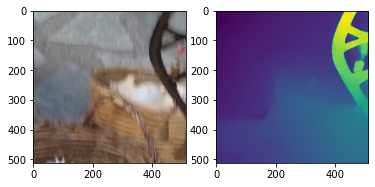

In [19]:

ble_dataset = BLEDataset(label_dir='E:/gopro/BLE_raw_bi_large/train.txt',train=True)
blur,ble=ble_dataset[7500]
print(blur.shape)
print(ble.shape)
plt.figure()
plt.subplot(1,2,1)
plt.imshow((blur.permute(1,2,0)+0.5))
plt.subplot(1,2,2)
plt.imshow(ble.squeeze())
print(blur)
print(ble)


In [20]:
from torch.utils.data import DataLoader

ble_dataset_train = BLEDataset(label_dir='E:/gopro/BLE_raw_bi_large/train.txt',train=True)
ble_dataset_test = BLEDataset(label_dir='E:/gopro/BLE_raw_bi_large/test.txt',train=False)
train_dl = DataLoader(ble_dataset_train,batch_size=8,shuffle=True)
test_dl = DataLoader(ble_dataset_test,batch_size=8,shuffle=False)

## Training settings

In [21]:
import os
import shutil
from datetime import datetime
from os.path import dirname, join

import torch


class Logger():
    def __init__(self):
        model_name="flownet"
        dataset_name="BLE"
        save_dir="E:/gopro/experiment"
        now = datetime.now() 
        now = now.strftime("%Y_%m_%d_%H_%M_%S")
        mark = model_name + '_' + dataset_name
        file_path = join(save_dir, now + '_' + mark, 'log.txt')
        self.save_dir = dirname(file_path)
        self.check_dir(file_path)
        self.logger = open(file_path, 'a+')
        # variable register
        self.register_dict = {}
        # tensorboard

    

    def check_dir(self, file_path):
        dir = dirname(file_path)
        os.makedirs(dir, exist_ok=True)

    def __call__(self, *args, verbose=True, prefix='', timestamp=True):
        if timestamp:
            now = datetime.now()
            now = now.strftime("%Y/%m/%d, %H:%M:%S - ")
        else:
            now = ''
        info = prefix + now
        for msg in args:
            if not isinstance(msg, str):
                msg = str(msg)
            info += msg + '\n'
        self.logger.write(info)
        if verbose:
            print(info, end='')
        self.logger.flush()

    def __del__(self):
        self.logger.close()

    # register values for each epoch, such as loss, PSNR etc.
    def register(self, name, epoch, value):
        if name in self.register_dict:
            self.register_dict[name][epoch] = value
            if value > self.register_dict[name]['max']:
                self.register_dict[name]['max'] = value
            if value < self.register_dict[name]['min']:
                self.register_dict[name]['min'] = value
        else:
            self.register_dict[name] = {}
            self.register_dict[name][epoch] = value
            self.register_dict[name]['max'] = value
            self.register_dict[name]['min'] = value

    def report(self, items, state, epoch):
        # items - [['MSE', 'min'], ['PSNR', 'max'] ... ]
        msg = '[{}] '.format(state.lower())
        state = '_' + state.lower()
        for i in range(len(items)):
            item, best = items[i]
            msg += '{} : {:.4f} (best {:.4f})'.format(
                item,
                self.register_dict[item + state][epoch],
                self.register_dict[item + state][best]
            )
            if i < len(items) - 1:
                msg += ', '
        self(msg, timestamp=False)

    def is_best(self, epoch):
        item = self.register_dict['L1' + '_valid']
        return item[epoch] == item['min']

    def save(self, state, filename='checkpoint.pth.tar'):
        path = join(self.save_dir, filename)
        torch.save(state, path)
        if self.is_best(state['epoch']):
            copy_path = join(self.save_dir, 'model_best.pth.tar')
            shutil.copy(path, copy_path)

In [22]:
from importlib import import_module

import torch.optim.lr_scheduler as lr_scheduler

class Optimizer:
    def __init__(self, target):
        # create optimizer
        # trainable = filter(lambda x: x.requires_grad, target.parameters())
        trainable = target.parameters()
        optimizer_name = 'Adam'
        lr = 3e-4
        module = import_module('torch.optim')
        self.optimizer = getattr(module, optimizer_name)(trainable, lr=lr)
        # create scheduler
        milestones = [200]
        gamma = 0.5
        
        self.scheduler = lr_scheduler.MultiStepLR(self.optimizer, milestones=milestones, gamma=gamma)
            

    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']

    def step(self):
        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

    def lr_schedule(self):
        self.scheduler.step()

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.nn.modules.loss import _Loss


def MSE(para):
    """
    L2 loss
    """
    return nn.MSELoss()


def L1(para):
    """
    L1 loss
    """
    return nn.L1Loss()


class L1GradientLoss(_Loss):
    """
    Gradient loss
    """

    def __init__(self):
        super(L1GradientLoss, self).__init__()
        self.get_grad = Gradient()
        self.L1 = nn.L1Loss()

    def forward(self, x, y):
        grad_x = self.get_grad(x)
        grad_y = self.get_grad(y)
        loss = self.L1(grad_x, grad_y)
        return loss

class Gradient(nn.Module):
    def __init__(self):
        super(Gradient, self).__init__()
        kernel_v = [[0, -1, 0],
                    [0, 0, 0],
                    [0, 1, 0]]
        kernel_h = [[0, 0, 0],
                    [-1, 0, 1],
                    [0, 0, 0]]
        kernel_h = torch.FloatTensor(kernel_h).unsqueeze(0).unsqueeze(0)
        kernel_v = torch.FloatTensor(kernel_v).unsqueeze(0).unsqueeze(0)
        self.weight_h = nn.Parameter(data=kernel_h, requires_grad=False).cuda()
        self.weight_v = nn.Parameter(data=kernel_v, requires_grad=False).cuda()

    def forward(self, x):
        x0 = x[:, 0]
        #x1 = x[:, 1]
        #x2 = x[:, 2]
        x0_v = F.conv2d(x0.unsqueeze(1), self.weight_v, padding=2)
        x0_h = F.conv2d(x0.unsqueeze(1), self.weight_h, padding=2)

        #x1_v = F.conv2d(x1.unsqueeze(1), self.weight_v, padding=2)
        #x1_h = F.conv2d(x1.unsqueeze(1), self.weight_h, padding=2)

        #x2_v = F.conv2d(x2.unsqueeze(1), self.weight_v, padding=2)
        #x2_h = F.conv2d(x2.unsqueeze(1), self.weight_h, padding=2)

        x0 = torch.sqrt(torch.pow(x0_v, 2) + torch.pow(x0_h, 2) + 1e-6)
        #x1 = torch.sqrt(torch.pow(x1_v, 2) + torch.pow(x1_h, 2) + 1e-6)
        #x2 = torch.sqrt(torch.pow(x2_v, 2) + torch.pow(x2_h, 2) + 1e-6)

        #x = torch.cat([x0, x1, x2], dim=1)
        x = x0
        return x
    


In [24]:
class AverageMeter(object):
    """
    computes and stores the average and current value
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

# set random seed
torch.manual_seed(39)
torch.cuda.manual_seed(39)
random.seed(39)
np.random.seed(39)

logger = Logger()
logger.writer = SummaryWriter("E:/gopro/experiment")
logger('building {} model ...')
model = UNet().cuda()

#model = torch.nn.DataParallel(RAFT(args))
#model.load_state_dict(torch.load(args.model))

#model = model.module
#model.to(DEVICE)

logger('model structure:', model, verbose=False)
model_name="flownet"

L1 = nn.L1Loss()

L1Grad = L1GradientLoss()

opt = Optimizer(model)
    
for epoch in range(400):
    #training
    model.train()
    logger('[Epoch {} / lr {:.2e}]'.format(epoch, opt.get_lr()), prefix='\n')

    losses_meter = {}
    losses_name = "L1"
    
    losses_meter= AverageMeter()

    measure_meter = AverageMeter()
    batchtime_meter = AverageMeter()

    start = time.time()
    end = time.time()
    pbar = tqdm(total=len(ble_dataset_train), ncols=80)
    for i,data in enumerate(train_dl):
        
        
        blur,label=data
        blur,label=blur.cuda(),label.cuda()
        
       # blur = (blur+0.5)*255
       # label =  label*150
        
       # padder = InputPadder(blur.shape)
       # blur, _ = padder.pad(blur, blur)

        #flow_low_12, flow_up_12 = model(blur, blur, iters=20, test_mode=True)
        ble=model(blur)
        #ble = torch.sqrt(flow_up_12[:,0,:,:]**2+flow_up_12[:,1,:,:]**2)
        #ble = ble.unsqueeze(1)
        
        loss=L1(ble,label)+0.5*L1Grad(ble,label)
        measure=L1(ble,label)
        losses_meter.update(loss.detach().item(), blur.size(0))
        measure_meter.update(measure.detach().item(), blur.size(0))
        
        opt.zero_grad() 
        loss.backward()
        opt.step()
        batchtime_meter.update(time.time() - end)
        end = time.time()
        pbar.update(blur.size(0))

      
    pbar.close()
    logger.register(losses_name + '_train', epoch, losses_meter.avg)
    logger.register(losses_name + '_train', epoch, measure_meter.avg)
    logger.writer.add_scalar(losses_name + '_loss_train', losses_meter.avg, epoch)
    logger.writer.add_scalar(losses_name + '_train', measure_meter.avg, epoch)
    logger.writer.add_scalar('lr', opt.get_lr(), epoch)
    logger('[train] epoch time: {:.2f}s, average batch time: {:.2f}s'.format(end - start, batchtime_meter.avg),
           timestamp=False)
    logger.report([[losses_name, 'min'], [losses_name, 'min']], state='train', epoch=epoch)
    opt.lr_schedule()
    
    #eval
    model.eval()

    with torch.no_grad():
        losses_meter = {}
        losses_name = "L1"
    
        losses_meter= AverageMeter()

        measure_meter = AverageMeter()
        batchtime_meter = AverageMeter()
        start = time.time()
        end = time.time()
        pbar = tqdm(total=len(ble_dataset_test), ncols=80)
        for i,data in enumerate(test_dl):
            blur,label=data
            blur,label=blur.cuda(),label.cuda()
            #ble=model(blur)
          #  blur = (blur+0.5)*255
          #  label =  label*150
            
          #  padder = InputPadder(blur.shape)
          #  blur, _ = padder.pad(blur, blur)

           # flow_low_12, flow_up_12 = model(blur, blur, iters=20, test_mode=True)
            ble=model(blur)
          #  ble = torch.sqrt(flow_up_12[:,0,:,:]**2+flow_up_12[:,1,:,:]**2)
          #  ble = ble.unsqueeze(1)
            
            loss=L1(ble,label)
            measure=L1(ble,label)
            losses_meter.update(loss.detach().item(), blur.size(0))
            measure_meter.update(measure.detach().item(), blur.size(0))
            
            batchtime_meter.update(time.time() - end)
            end = time.time()
            pbar.update(blur.size(0))
            
  
            
    pbar.close()
    logger.register(losses_name + '_valid', epoch, losses_meter.avg)
    logger.register(losses_name + '_valid', epoch, measure_meter.avg)
    logger.writer.add_scalar(losses_name + '_loss_valid', losses_meter.avg, epoch)
    logger.writer.add_scalar(losses_name + '_valid', measure_meter.avg, epoch)
    logger.writer.add_scalar('lr', opt.get_lr(), epoch)
    logger('[valid] epoch time: {:.2f}s, average batch time: {:.2f}s'.format(end - start, batchtime_meter.avg),
           timestamp=False)
    logger.report([[losses_name, 'min'], [losses_name, 'min']], state='valid', epoch=epoch)
    
    checkpoint = {
            'epoch': epoch,
            'model': model_name,
            'state_dict': model.state_dict(),
            'register_dict': logger.register_dict,
            'optimizer': opt.optimizer.state_dict(),
            'scheduler': opt.scheduler.state_dict()
        }
    logger.save(checkpoint)

  0%|                                                 | 0/15691 [00:00<?, ?it/s]

2022/03/10, 19:00:55 - building {} model ...

2022/03/10, 19:00:55 - [Epoch 0 / lr 3.00e-04]


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1614: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2627.01s, average batch time: 1.34s
[train] L1 : 0.0603 (best 0.0603), L1 : 0.0603 (best 0.0603)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 141.16s, average batch time: 1.02s
[valid] L1 : 0.0370 (best 0.0370), L1 : 0.0370 (best 0.0370)

2022/03/10, 19:47:03 - [Epoch 1 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2092.81s, average batch time: 1.07s
[train] L1 : 0.0498 (best 0.0498), L1 : 0.0498 (best 0.0498)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.35s, average batch time: 0.56s
[valid] L1 : 0.0325 (best 0.0325), L1 : 0.0325 (best 0.0325)

2022/03/10, 20:23:13 - [Epoch 2 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1745.51s, average batch time: 0.89s
[train] L1 : 0.0445 (best 0.0445), L1 : 0.0445 (best 0.0445)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 106.48s, average batch time: 0.77s
[valid] L1 : 0.0307 (best 0.0307), L1 : 0.0307 (best 0.0307)

2022/03/10, 20:54:05 - [Epoch 3 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1739.78s, average batch time: 0.89s
[train] L1 : 0.0408 (best 0.0408), L1 : 0.0408 (best 0.0408)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 113.54s, average batch time: 0.82s
[valid] L1 : 0.0370 (best 0.0307), L1 : 0.0370 (best 0.0307)

2022/03/10, 21:24:59 - [Epoch 4 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1772.56s, average batch time: 0.90s
[train] L1 : 0.0379 (best 0.0379), L1 : 0.0379 (best 0.0379)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 105.86s, average batch time: 0.76s
[valid] L1 : 0.0285 (best 0.0285), L1 : 0.0285 (best 0.0285)

2022/03/10, 21:56:17 - [Epoch 5 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1784.76s, average batch time: 0.91s
[train] L1 : 0.0356 (best 0.0356), L1 : 0.0356 (best 0.0356)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 110.98s, average batch time: 0.80s
[valid] L1 : 0.0283 (best 0.0283), L1 : 0.0283 (best 0.0283)

2022/03/10, 22:27:53 - [Epoch 6 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1731.98s, average batch time: 0.88s
[train] L1 : 0.0342 (best 0.0342), L1 : 0.0342 (best 0.0342)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 105.02s, average batch time: 0.76s
[valid] L1 : 0.0263 (best 0.0263), L1 : 0.0263 (best 0.0263)

2022/03/10, 22:58:30 - [Epoch 7 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1758.91s, average batch time: 0.90s
[train] L1 : 0.0326 (best 0.0326), L1 : 0.0326 (best 0.0326)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 111.05s, average batch time: 0.80s
[valid] L1 : 0.0269 (best 0.0263), L1 : 0.0269 (best 0.0263)

2022/03/10, 23:29:40 - [Epoch 8 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1707.79s, average batch time: 0.87s
[train] L1 : 0.0314 (best 0.0314), L1 : 0.0314 (best 0.0314)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 106.22s, average batch time: 0.76s
[valid] L1 : 0.0261 (best 0.0261), L1 : 0.0261 (best 0.0261)

2022/03/10, 23:59:54 - [Epoch 9 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1758.18s, average batch time: 0.90s
[train] L1 : 0.0302 (best 0.0302), L1 : 0.0302 (best 0.0302)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 116.14s, average batch time: 0.84s
[valid] L1 : 0.0246 (best 0.0246), L1 : 0.0246 (best 0.0246)

2022/03/11, 00:31:09 - [Epoch 10 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1745.29s, average batch time: 0.89s
[train] L1 : 0.0295 (best 0.0295), L1 : 0.0295 (best 0.0295)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 94.13s, average batch time: 0.68s
[valid] L1 : 0.0247 (best 0.0246), L1 : 0.0247 (best 0.0246)

2022/03/11, 01:01:48 - [Epoch 11 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1757.96s, average batch time: 0.90s
[train] L1 : 0.0283 (best 0.0283), L1 : 0.0283 (best 0.0283)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 117.27s, average batch time: 0.84s
[valid] L1 : 0.0240 (best 0.0240), L1 : 0.0240 (best 0.0240)

2022/03/11, 01:33:04 - [Epoch 12 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1753.12s, average batch time: 0.89s
[train] L1 : 0.0277 (best 0.0277), L1 : 0.0277 (best 0.0277)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 98.10s, average batch time: 0.71s
[valid] L1 : 0.0242 (best 0.0240), L1 : 0.0242 (best 0.0240)

2022/03/11, 02:03:55 - [Epoch 13 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1743.11s, average batch time: 0.89s
[train] L1 : 0.0268 (best 0.0268), L1 : 0.0268 (best 0.0268)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 117.45s, average batch time: 0.84s
[valid] L1 : 0.0235 (best 0.0235), L1 : 0.0235 (best 0.0235)

2022/03/11, 02:34:56 - [Epoch 14 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1738.39s, average batch time: 0.89s
[train] L1 : 0.0260 (best 0.0260), L1 : 0.0260 (best 0.0260)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 98.37s, average batch time: 0.71s
[valid] L1 : 0.0225 (best 0.0225), L1 : 0.0225 (best 0.0225)

2022/03/11, 03:05:32 - [Epoch 15 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1739.94s, average batch time: 0.89s
[train] L1 : 0.0253 (best 0.0253), L1 : 0.0253 (best 0.0253)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 116.59s, average batch time: 0.84s
[valid] L1 : 0.0246 (best 0.0225), L1 : 0.0246 (best 0.0225)

2022/03/11, 03:36:29 - [Epoch 16 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1753.44s, average batch time: 0.89s
[train] L1 : 0.0246 (best 0.0246), L1 : 0.0246 (best 0.0246)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 99.36s, average batch time: 0.71s
[valid] L1 : 0.0215 (best 0.0215), L1 : 0.0215 (best 0.0215)

2022/03/11, 04:07:22 - [Epoch 17 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1750.33s, average batch time: 0.89s
[train] L1 : 0.0238 (best 0.0238), L1 : 0.0238 (best 0.0238)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 118.97s, average batch time: 0.86s
[valid] L1 : 0.0217 (best 0.0215), L1 : 0.0217 (best 0.0215)

2022/03/11, 04:38:31 - [Epoch 18 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1738.29s, average batch time: 0.89s
[train] L1 : 0.0231 (best 0.0231), L1 : 0.0231 (best 0.0231)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 95.29s, average batch time: 0.69s
[valid] L1 : 0.0209 (best 0.0209), L1 : 0.0209 (best 0.0209)

2022/03/11, 05:09:05 - [Epoch 19 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1761.24s, average batch time: 0.90s
[train] L1 : 0.0230 (best 0.0230), L1 : 0.0230 (best 0.0230)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 107.75s, average batch time: 0.78s
[valid] L1 : 0.0232 (best 0.0209), L1 : 0.0232 (best 0.0209)

2022/03/11, 05:40:14 - [Epoch 20 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1793.53s, average batch time: 0.91s
[train] L1 : 0.0224 (best 0.0224), L1 : 0.0224 (best 0.0224)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 110.93s, average batch time: 0.80s
[valid] L1 : 0.0205 (best 0.0205), L1 : 0.0205 (best 0.0205)

2022/03/11, 06:11:59 - [Epoch 21 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1747.87s, average batch time: 0.89s
[train] L1 : 0.0217 (best 0.0217), L1 : 0.0217 (best 0.0217)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 106.15s, average batch time: 0.76s
[valid] L1 : 0.0222 (best 0.0205), L1 : 0.0222 (best 0.0205)

2022/03/11, 06:42:53 - [Epoch 22 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1754.74s, average batch time: 0.89s
[train] L1 : 0.0213 (best 0.0213), L1 : 0.0213 (best 0.0213)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 110.59s, average batch time: 0.80s
[valid] L1 : 0.0196 (best 0.0196), L1 : 0.0196 (best 0.0196)

2022/03/11, 07:13:58 - [Epoch 23 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1744.58s, average batch time: 0.89s
[train] L1 : 0.0210 (best 0.0210), L1 : 0.0210 (best 0.0210)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 107.00s, average batch time: 0.77s
[valid] L1 : 0.0189 (best 0.0189), L1 : 0.0189 (best 0.0189)

2022/03/11, 07:44:50 - [Epoch 24 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1768.18s, average batch time: 0.90s
[train] L1 : 0.0207 (best 0.0207), L1 : 0.0207 (best 0.0207)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 111.68s, average batch time: 0.80s
[valid] L1 : 0.0198 (best 0.0189), L1 : 0.0198 (best 0.0189)

2022/03/11, 08:16:10 - [Epoch 25 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1777.37s, average batch time: 0.91s
[train] L1 : 0.0203 (best 0.0203), L1 : 0.0203 (best 0.0203)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 106.46s, average batch time: 0.77s
[valid] L1 : 0.0181 (best 0.0181), L1 : 0.0181 (best 0.0181)

2022/03/11, 08:47:34 - [Epoch 26 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1751.27s, average batch time: 0.89s
[train] L1 : 0.0200 (best 0.0200), L1 : 0.0200 (best 0.0200)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 109.38s, average batch time: 0.79s
[valid] L1 : 0.0183 (best 0.0181), L1 : 0.0183 (best 0.0181)

2022/03/11, 09:18:34 - [Epoch 27 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1801.74s, average batch time: 0.92s
[train] L1 : 0.0197 (best 0.0197), L1 : 0.0197 (best 0.0197)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 107.62s, average batch time: 0.77s
[valid] L1 : 0.0191 (best 0.0181), L1 : 0.0191 (best 0.0181)

2022/03/11, 09:50:24 - [Epoch 28 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1761.75s, average batch time: 0.90s
[train] L1 : 0.0195 (best 0.0195), L1 : 0.0195 (best 0.0195)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 109.68s, average batch time: 0.79s
[valid] L1 : 0.0184 (best 0.0181), L1 : 0.0184 (best 0.0181)

2022/03/11, 10:21:35 - [Epoch 29 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1742.70s, average batch time: 0.89s
[train] L1 : 0.0191 (best 0.0191), L1 : 0.0191 (best 0.0191)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 109.77s, average batch time: 0.79s
[valid] L1 : 0.0207 (best 0.0181), L1 : 0.0207 (best 0.0181)

2022/03/11, 10:52:28 - [Epoch 30 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1774.47s, average batch time: 0.90s
[train] L1 : 0.0189 (best 0.0189), L1 : 0.0189 (best 0.0189)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 107.32s, average batch time: 0.77s
[valid] L1 : 0.0199 (best 0.0181), L1 : 0.0199 (best 0.0181)

2022/03/11, 11:23:50 - [Epoch 31 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1730.79s, average batch time: 0.88s
[train] L1 : 0.0185 (best 0.0185), L1 : 0.0185 (best 0.0185)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 102.22s, average batch time: 0.74s
[valid] L1 : 0.0177 (best 0.0177), L1 : 0.0177 (best 0.0177)

2022/03/11, 11:54:23 - [Epoch 32 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1789.39s, average batch time: 0.91s
[train] L1 : 0.0186 (best 0.0185), L1 : 0.0186 (best 0.0185)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 114.04s, average batch time: 0.82s
[valid] L1 : 0.0198 (best 0.0177), L1 : 0.0198 (best 0.0177)

2022/03/11, 12:26:06 - [Epoch 33 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1781.17s, average batch time: 0.91s
[train] L1 : 0.0180 (best 0.0180), L1 : 0.0180 (best 0.0180)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 104.16s, average batch time: 0.75s
[valid] L1 : 0.0182 (best 0.0177), L1 : 0.0182 (best 0.0177)

2022/03/11, 12:57:32 - [Epoch 34 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1789.84s, average batch time: 0.91s
[train] L1 : 0.0178 (best 0.0178), L1 : 0.0178 (best 0.0178)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 109.01s, average batch time: 0.78s
[valid] L1 : 0.0185 (best 0.0177), L1 : 0.0185 (best 0.0177)

2022/03/11, 13:29:11 - [Epoch 35 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1740.85s, average batch time: 0.89s
[train] L1 : 0.0175 (best 0.0175), L1 : 0.0175 (best 0.0175)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.67s, average batch time: 0.78s
[valid] L1 : 0.0171 (best 0.0171), L1 : 0.0171 (best 0.0171)

2022/03/11, 14:00:00 - [Epoch 36 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1833.57s, average batch time: 0.93s
[train] L1 : 0.0174 (best 0.0174), L1 : 0.0174 (best 0.0174)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 141.03s, average batch time: 1.01s
[valid] L1 : 0.0179 (best 0.0171), L1 : 0.0179 (best 0.0171)

2022/03/11, 14:32:55 - [Epoch 37 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2187.77s, average batch time: 1.12s
[train] L1 : 0.0171 (best 0.0171), L1 : 0.0171 (best 0.0171)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.51s, average batch time: 0.78s
[valid] L1 : 0.0184 (best 0.0171), L1 : 0.0184 (best 0.0171)

2022/03/11, 15:11:11 - [Epoch 38 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1801.84s, average batch time: 0.92s
[train] L1 : 0.0171 (best 0.0171), L1 : 0.0171 (best 0.0171)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 109.10s, average batch time: 0.78s
[valid] L1 : 0.0185 (best 0.0171), L1 : 0.0185 (best 0.0171)

2022/03/11, 15:43:02 - [Epoch 39 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1745.84s, average batch time: 0.89s
[train] L1 : 0.0169 (best 0.0169), L1 : 0.0169 (best 0.0169)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 107.30s, average batch time: 0.77s
[valid] L1 : 0.0191 (best 0.0171), L1 : 0.0191 (best 0.0171)

2022/03/11, 16:13:55 - [Epoch 40 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1737.00s, average batch time: 0.89s
[train] L1 : 0.0165 (best 0.0165), L1 : 0.0165 (best 0.0165)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 116.22s, average batch time: 0.84s
[valid] L1 : 0.0188 (best 0.0171), L1 : 0.0188 (best 0.0171)

2022/03/11, 16:44:49 - [Epoch 41 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1755.90s, average batch time: 0.89s
[train] L1 : 0.0164 (best 0.0164), L1 : 0.0164 (best 0.0164)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 107.06s, average batch time: 0.77s
[valid] L1 : 0.0177 (best 0.0171), L1 : 0.0177 (best 0.0171)

2022/03/11, 17:15:52 - [Epoch 42 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1767.27s, average batch time: 0.90s
[train] L1 : 0.0162 (best 0.0162), L1 : 0.0162 (best 0.0162)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 110.43s, average batch time: 0.79s
[valid] L1 : 0.0171 (best 0.0171), L1 : 0.0171 (best 0.0171)

2022/03/11, 17:47:09 - [Epoch 43 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1746.45s, average batch time: 0.89s
[train] L1 : 0.0160 (best 0.0160), L1 : 0.0160 (best 0.0160)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.41s, average batch time: 0.78s
[valid] L1 : 0.0182 (best 0.0171), L1 : 0.0182 (best 0.0171)

2022/03/11, 18:18:04 - [Epoch 44 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1758.04s, average batch time: 0.90s
[train] L1 : 0.0158 (best 0.0158), L1 : 0.0158 (best 0.0158)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 110.93s, average batch time: 0.80s
[valid] L1 : 0.0188 (best 0.0171), L1 : 0.0188 (best 0.0171)

2022/03/11, 18:49:14 - [Epoch 45 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1761.79s, average batch time: 0.90s
[train] L1 : 0.0158 (best 0.0158), L1 : 0.0158 (best 0.0158)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 107.42s, average batch time: 0.77s
[valid] L1 : 0.0190 (best 0.0171), L1 : 0.0190 (best 0.0171)

2022/03/11, 19:20:23 - [Epoch 46 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1910.33s, average batch time: 0.97s
[train] L1 : 0.0155 (best 0.0155), L1 : 0.0155 (best 0.0155)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 142.36s, average batch time: 1.02s
[valid] L1 : 0.0187 (best 0.0171), L1 : 0.0187 (best 0.0171)

2022/03/11, 19:54:36 - [Epoch 47 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1980.92s, average batch time: 1.01s
[train] L1 : 0.0155 (best 0.0155), L1 : 0.0155 (best 0.0155)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 107.99s, average batch time: 0.78s
[valid] L1 : 0.0183 (best 0.0171), L1 : 0.0183 (best 0.0171)

2022/03/11, 20:29:25 - [Epoch 48 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1775.20s, average batch time: 0.90s
[train] L1 : 0.0151 (best 0.0151), L1 : 0.0151 (best 0.0151)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 109.82s, average batch time: 0.79s
[valid] L1 : 0.0206 (best 0.0171), L1 : 0.0206 (best 0.0171)

2022/03/11, 21:00:50 - [Epoch 49 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1787.92s, average batch time: 0.91s
[train] L1 : 0.0151 (best 0.0151), L1 : 0.0151 (best 0.0151)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 109.12s, average batch time: 0.79s
[valid] L1 : 0.0163 (best 0.0163), L1 : 0.0163 (best 0.0163)

2022/03/11, 21:32:27 - [Epoch 50 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1799.80s, average batch time: 0.92s
[train] L1 : 0.0149 (best 0.0149), L1 : 0.0149 (best 0.0149)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 111.58s, average batch time: 0.80s
[valid] L1 : 0.0165 (best 0.0163), L1 : 0.0165 (best 0.0163)

2022/03/11, 22:04:18 - [Epoch 51 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1764.36s, average batch time: 0.90s
[train] L1 : 0.0149 (best 0.0149), L1 : 0.0149 (best 0.0149)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 100.98s, average batch time: 0.73s
[valid] L1 : 0.0184 (best 0.0163), L1 : 0.0184 (best 0.0163)

2022/03/11, 22:35:24 - [Epoch 52 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1768.62s, average batch time: 0.90s
[train] L1 : 0.0149 (best 0.0149), L1 : 0.0149 (best 0.0149)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 98.10s, average batch time: 0.71s
[valid] L1 : 0.0186 (best 0.0163), L1 : 0.0186 (best 0.0163)

2022/03/11, 23:06:30 - [Epoch 53 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1734.46s, average batch time: 0.88s
[train] L1 : 0.0146 (best 0.0146), L1 : 0.0146 (best 0.0146)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 121.08s, average batch time: 0.87s
[valid] L1 : 0.0176 (best 0.0163), L1 : 0.0176 (best 0.0163)

2022/03/11, 23:37:26 - [Epoch 54 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1766.14s, average batch time: 0.90s
[train] L1 : 0.0145 (best 0.0145), L1 : 0.0145 (best 0.0145)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 96.67s, average batch time: 0.70s
[valid] L1 : 0.0190 (best 0.0163), L1 : 0.0190 (best 0.0163)

2022/03/12, 00:08:29 - [Epoch 55 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1750.49s, average batch time: 0.89s
[train] L1 : 0.0144 (best 0.0144), L1 : 0.0144 (best 0.0144)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 115.93s, average batch time: 0.83s
[valid] L1 : 0.0160 (best 0.0160), L1 : 0.0160 (best 0.0160)

2022/03/12, 00:39:35 - [Epoch 56 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1768.75s, average batch time: 0.90s
[train] L1 : 0.0142 (best 0.0142), L1 : 0.0142 (best 0.0142)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 100.82s, average batch time: 0.73s
[valid] L1 : 0.0180 (best 0.0160), L1 : 0.0180 (best 0.0160)

2022/03/12, 01:10:45 - [Epoch 57 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1744.25s, average batch time: 0.89s
[train] L1 : 0.0141 (best 0.0141), L1 : 0.0141 (best 0.0141)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 133.07s, average batch time: 0.96s
[valid] L1 : 0.0190 (best 0.0160), L1 : 0.0190 (best 0.0160)

2022/03/12, 01:42:02 - [Epoch 58 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1738.46s, average batch time: 0.89s
[train] L1 : 0.0139 (best 0.0139), L1 : 0.0139 (best 0.0139)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 98.08s, average batch time: 0.71s
[valid] L1 : 0.0166 (best 0.0160), L1 : 0.0166 (best 0.0160)

2022/03/12, 02:12:39 - [Epoch 59 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1794.12s, average batch time: 0.91s
[train] L1 : 0.0141 (best 0.0139), L1 : 0.0141 (best 0.0139)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.98s, average batch time: 0.78s
[valid] L1 : 0.0157 (best 0.0157), L1 : 0.0157 (best 0.0157)

2022/03/12, 02:44:22 - [Epoch 60 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1765.66s, average batch time: 0.90s
[train] L1 : 0.0139 (best 0.0139), L1 : 0.0139 (best 0.0139)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.83s, average batch time: 0.78s
[valid] L1 : 0.0168 (best 0.0157), L1 : 0.0168 (best 0.0157)

2022/03/12, 03:15:37 - [Epoch 61 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1773.60s, average batch time: 0.90s
[train] L1 : 0.0138 (best 0.0138), L1 : 0.0138 (best 0.0138)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 110.21s, average batch time: 0.79s
[valid] L1 : 0.0165 (best 0.0157), L1 : 0.0165 (best 0.0157)

2022/03/12, 03:47:01 - [Epoch 62 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1751.65s, average batch time: 0.89s
[train] L1 : 0.0136 (best 0.0136), L1 : 0.0136 (best 0.0136)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.92s, average batch time: 0.78s
[valid] L1 : 0.0183 (best 0.0157), L1 : 0.0183 (best 0.0157)

2022/03/12, 04:18:01 - [Epoch 63 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1718.86s, average batch time: 0.88s
[train] L1 : 0.0135 (best 0.0135), L1 : 0.0135 (best 0.0135)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.52s, average batch time: 0.78s
[valid] L1 : 0.0160 (best 0.0157), L1 : 0.0160 (best 0.0157)

2022/03/12, 04:48:29 - [Epoch 64 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1748.70s, average batch time: 0.89s
[train] L1 : 0.0135 (best 0.0135), L1 : 0.0135 (best 0.0135)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.56s, average batch time: 0.78s
[valid] L1 : 0.0159 (best 0.0157), L1 : 0.0159 (best 0.0157)

2022/03/12, 05:19:26 - [Epoch 65 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1737.55s, average batch time: 0.89s
[train] L1 : 0.0134 (best 0.0134), L1 : 0.0134 (best 0.0134)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.10s, average batch time: 0.78s
[valid] L1 : 0.0176 (best 0.0157), L1 : 0.0176 (best 0.0157)

2022/03/12, 05:50:12 - [Epoch 66 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1771.16s, average batch time: 0.90s
[train] L1 : 0.0133 (best 0.0133), L1 : 0.0133 (best 0.0133)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.76s, average batch time: 0.78s
[valid] L1 : 0.0172 (best 0.0157), L1 : 0.0172 (best 0.0157)

2022/03/12, 06:21:32 - [Epoch 67 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1767.95s, average batch time: 0.90s
[train] L1 : 0.0132 (best 0.0132), L1 : 0.0132 (best 0.0132)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.25s, average batch time: 0.78s
[valid] L1 : 0.0165 (best 0.0157), L1 : 0.0165 (best 0.0157)

2022/03/12, 06:52:48 - [Epoch 68 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1757.11s, average batch time: 0.90s
[train] L1 : 0.0134 (best 0.0132), L1 : 0.0134 (best 0.0132)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 112.35s, average batch time: 0.81s
[valid] L1 : 0.0170 (best 0.0157), L1 : 0.0170 (best 0.0157)

2022/03/12, 07:23:58 - [Epoch 69 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1768.37s, average batch time: 0.90s
[train] L1 : 0.0130 (best 0.0130), L1 : 0.0130 (best 0.0130)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.70s, average batch time: 0.78s
[valid] L1 : 0.0180 (best 0.0157), L1 : 0.0180 (best 0.0157)

2022/03/12, 07:55:15 - [Epoch 70 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1719.50s, average batch time: 0.88s
[train] L1 : 0.0130 (best 0.0130), L1 : 0.0130 (best 0.0130)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 112.48s, average batch time: 0.81s
[valid] L1 : 0.0182 (best 0.0157), L1 : 0.0182 (best 0.0157)

2022/03/12, 08:25:47 - [Epoch 71 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1785.11s, average batch time: 0.91s
[train] L1 : 0.0129 (best 0.0129), L1 : 0.0129 (best 0.0129)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 130.66s, average batch time: 0.94s
[valid] L1 : 0.0161 (best 0.0157), L1 : 0.0161 (best 0.0157)

2022/03/12, 08:57:43 - [Epoch 72 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1760.34s, average batch time: 0.90s
[train] L1 : 0.0129 (best 0.0129), L1 : 0.0129 (best 0.0129)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 136.49s, average batch time: 0.98s
[valid] L1 : 0.0175 (best 0.0157), L1 : 0.0175 (best 0.0157)

2022/03/12, 09:29:20 - [Epoch 73 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1759.26s, average batch time: 0.90s
[train] L1 : 0.0128 (best 0.0128), L1 : 0.0128 (best 0.0128)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 105.17s, average batch time: 0.76s
[valid] L1 : 0.0174 (best 0.0157), L1 : 0.0174 (best 0.0157)

2022/03/12, 10:00:24 - [Epoch 74 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1762.40s, average batch time: 0.90s
[train] L1 : 0.0127 (best 0.0127), L1 : 0.0127 (best 0.0127)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 112.82s, average batch time: 0.81s
[valid] L1 : 0.0169 (best 0.0157), L1 : 0.0169 (best 0.0157)

2022/03/12, 10:31:39 - [Epoch 75 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1772.85s, average batch time: 0.90s
[train] L1 : 0.0127 (best 0.0127), L1 : 0.0127 (best 0.0127)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 104.34s, average batch time: 0.75s
[valid] L1 : 0.0176 (best 0.0157), L1 : 0.0176 (best 0.0157)

2022/03/12, 11:02:57 - [Epoch 76 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1773.52s, average batch time: 0.90s
[train] L1 : 0.0126 (best 0.0126), L1 : 0.0126 (best 0.0126)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 112.38s, average batch time: 0.81s
[valid] L1 : 0.0172 (best 0.0157), L1 : 0.0172 (best 0.0157)

2022/03/12, 11:34:23 - [Epoch 77 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1747.34s, average batch time: 0.89s
[train] L1 : 0.0126 (best 0.0126), L1 : 0.0126 (best 0.0126)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 104.76s, average batch time: 0.75s
[valid] L1 : 0.0164 (best 0.0157), L1 : 0.0164 (best 0.0157)

2022/03/12, 12:05:15 - [Epoch 78 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1745.11s, average batch time: 0.89s
[train] L1 : 0.0125 (best 0.0125), L1 : 0.0125 (best 0.0125)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 111.93s, average batch time: 0.81s
[valid] L1 : 0.0209 (best 0.0157), L1 : 0.0209 (best 0.0157)

2022/03/12, 12:36:12 - [Epoch 79 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2214.13s, average batch time: 1.13s
[train] L1 : 0.0125 (best 0.0125), L1 : 0.0125 (best 0.0125)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 146.09s, average batch time: 1.05s
[valid] L1 : 0.0167 (best 0.0157), L1 : 0.0167 (best 0.0157)

2022/03/12, 13:15:32 - [Epoch 80 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1839.87s, average batch time: 0.94s
[train] L1 : 0.0124 (best 0.0124), L1 : 0.0124 (best 0.0124)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 107.39s, average batch time: 0.77s
[valid] L1 : 0.0158 (best 0.0157), L1 : 0.0158 (best 0.0157)

2022/03/12, 13:48:00 - [Epoch 81 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1736.76s, average batch time: 0.89s
[train] L1 : 0.0123 (best 0.0123), L1 : 0.0123 (best 0.0123)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 101.04s, average batch time: 0.73s
[valid] L1 : 0.0164 (best 0.0157), L1 : 0.0164 (best 0.0157)

2022/03/12, 14:18:37 - [Epoch 82 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1769.76s, average batch time: 0.90s
[train] L1 : 0.0123 (best 0.0123), L1 : 0.0123 (best 0.0123)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 104.78s, average batch time: 0.75s
[valid] L1 : 0.0150 (best 0.0150), L1 : 0.0150 (best 0.0150)

2022/03/12, 14:49:52 - [Epoch 83 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1800.56s, average batch time: 0.92s
[train] L1 : 0.0122 (best 0.0122), L1 : 0.0122 (best 0.0122)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 112.84s, average batch time: 0.81s
[valid] L1 : 0.0190 (best 0.0150), L1 : 0.0190 (best 0.0150)

2022/03/12, 15:21:46 - [Epoch 84 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1715.66s, average batch time: 0.87s
[train] L1 : 0.0121 (best 0.0121), L1 : 0.0121 (best 0.0121)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 104.75s, average batch time: 0.75s
[valid] L1 : 0.0171 (best 0.0150), L1 : 0.0171 (best 0.0150)

2022/03/12, 15:52:06 - [Epoch 85 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1788.72s, average batch time: 0.91s
[train] L1 : 0.0122 (best 0.0121), L1 : 0.0122 (best 0.0121)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 111.52s, average batch time: 0.80s
[valid] L1 : 0.0157 (best 0.0150), L1 : 0.0157 (best 0.0150)

2022/03/12, 16:23:46 - [Epoch 86 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1750.56s, average batch time: 0.89s
[train] L1 : 0.0122 (best 0.0121), L1 : 0.0122 (best 0.0121)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 104.50s, average batch time: 0.75s
[valid] L1 : 0.0152 (best 0.0150), L1 : 0.0152 (best 0.0150)

2022/03/12, 16:54:41 - [Epoch 87 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1769.80s, average batch time: 0.90s
[train] L1 : 0.0120 (best 0.0120), L1 : 0.0120 (best 0.0120)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 112.28s, average batch time: 0.81s
[valid] L1 : 0.0175 (best 0.0150), L1 : 0.0175 (best 0.0150)

2022/03/12, 17:26:04 - [Epoch 88 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1743.51s, average batch time: 0.89s
[train] L1 : 0.0120 (best 0.0120), L1 : 0.0120 (best 0.0120)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 105.54s, average batch time: 0.76s
[valid] L1 : 0.0166 (best 0.0150), L1 : 0.0166 (best 0.0150)

2022/03/12, 17:56:53 - [Epoch 89 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1799.84s, average batch time: 0.92s
[train] L1 : 0.0118 (best 0.0118), L1 : 0.0118 (best 0.0118)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 114.87s, average batch time: 0.83s
[valid] L1 : 0.0168 (best 0.0150), L1 : 0.0168 (best 0.0150)

2022/03/12, 18:28:48 - [Epoch 90 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1808.64s, average batch time: 0.92s
[train] L1 : 0.0120 (best 0.0118), L1 : 0.0120 (best 0.0118)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 109.97s, average batch time: 0.79s
[valid] L1 : 0.0159 (best 0.0150), L1 : 0.0159 (best 0.0150)

2022/03/12, 19:00:46 - [Epoch 91 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1791.77s, average batch time: 0.91s
[train] L1 : 0.0119 (best 0.0118), L1 : 0.0119 (best 0.0118)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 110.97s, average batch time: 0.80s
[valid] L1 : 0.0163 (best 0.0150), L1 : 0.0163 (best 0.0150)

2022/03/12, 19:32:29 - [Epoch 92 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1821.79s, average batch time: 0.93s
[train] L1 : 0.0118 (best 0.0118), L1 : 0.0118 (best 0.0118)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 105.49s, average batch time: 0.76s
[valid] L1 : 0.0153 (best 0.0150), L1 : 0.0153 (best 0.0150)

2022/03/12, 20:04:36 - [Epoch 93 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1823.08s, average batch time: 0.93s
[train] L1 : 0.0118 (best 0.0118), L1 : 0.0118 (best 0.0118)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 103.93s, average batch time: 0.75s
[valid] L1 : 0.0159 (best 0.0150), L1 : 0.0159 (best 0.0150)

2022/03/12, 20:36:43 - [Epoch 94 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1812.93s, average batch time: 0.92s
[train] L1 : 0.0118 (best 0.0118), L1 : 0.0118 (best 0.0118)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 118.25s, average batch time: 0.85s
[valid] L1 : 0.0197 (best 0.0150), L1 : 0.0197 (best 0.0150)

2022/03/12, 21:08:55 - [Epoch 95 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1787.98s, average batch time: 0.91s
[train] L1 : 0.0117 (best 0.0117), L1 : 0.0117 (best 0.0117)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 112.10s, average batch time: 0.81s
[valid] L1 : 0.0162 (best 0.0150), L1 : 0.0162 (best 0.0150)

2022/03/12, 21:40:35 - [Epoch 96 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1820.46s, average batch time: 0.93s
[train] L1 : 0.0116 (best 0.0116), L1 : 0.0116 (best 0.0116)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.31s, average batch time: 0.78s
[valid] L1 : 0.0160 (best 0.0150), L1 : 0.0160 (best 0.0150)

2022/03/12, 22:12:44 - [Epoch 97 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1799.31s, average batch time: 0.92s
[train] L1 : 0.0116 (best 0.0116), L1 : 0.0116 (best 0.0116)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 88.72s, average batch time: 0.64s
[valid] L1 : 0.0164 (best 0.0150), L1 : 0.0164 (best 0.0150)

2022/03/12, 22:44:12 - [Epoch 98 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1825.81s, average batch time: 0.93s
[train] L1 : 0.0116 (best 0.0116), L1 : 0.0116 (best 0.0116)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 128.11s, average batch time: 0.92s
[valid] L1 : 0.0148 (best 0.0148), L1 : 0.0148 (best 0.0148)

2022/03/12, 23:16:46 - [Epoch 99 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1810.84s, average batch time: 0.92s
[train] L1 : 0.0115 (best 0.0115), L1 : 0.0115 (best 0.0115)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 94.18s, average batch time: 0.68s
[valid] L1 : 0.0195 (best 0.0148), L1 : 0.0195 (best 0.0148)

2022/03/12, 23:48:31 - [Epoch 100 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1764.45s, average batch time: 0.90s
[train] L1 : 0.0114 (best 0.0114), L1 : 0.0114 (best 0.0114)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 127.59s, average batch time: 0.92s
[valid] L1 : 0.0161 (best 0.0148), L1 : 0.0161 (best 0.0148)

2022/03/13, 00:20:03 - [Epoch 101 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1798.01s, average batch time: 0.92s
[train] L1 : 0.0114 (best 0.0114), L1 : 0.0114 (best 0.0114)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 93.85s, average batch time: 0.68s
[valid] L1 : 0.0179 (best 0.0148), L1 : 0.0179 (best 0.0148)

2022/03/13, 00:51:35 - [Epoch 102 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1764.00s, average batch time: 0.90s
[train] L1 : 0.0115 (best 0.0114), L1 : 0.0115 (best 0.0114)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 127.77s, average batch time: 0.92s
[valid] L1 : 0.0149 (best 0.0148), L1 : 0.0149 (best 0.0148)

2022/03/13, 01:23:07 - [Epoch 103 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1819.35s, average batch time: 0.93s
[train] L1 : 0.0113 (best 0.0113), L1 : 0.0113 (best 0.0113)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 94.32s, average batch time: 0.68s
[valid] L1 : 0.0161 (best 0.0148), L1 : 0.0161 (best 0.0148)

2022/03/13, 01:55:01 - [Epoch 104 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1920.73s, average batch time: 0.98s
[train] L1 : 0.0113 (best 0.0113), L1 : 0.0113 (best 0.0113)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 87.52s, average batch time: 0.63s
[valid] L1 : 0.0180 (best 0.0148), L1 : 0.0180 (best 0.0148)

2022/03/13, 02:28:29 - [Epoch 105 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2011.89s, average batch time: 1.03s
[train] L1 : 0.0112 (best 0.0112), L1 : 0.0112 (best 0.0112)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 78.54s, average batch time: 0.57s
[valid] L1 : 0.0151 (best 0.0148), L1 : 0.0151 (best 0.0148)

2022/03/13, 03:03:19 - [Epoch 106 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1902.51s, average batch time: 0.97s
[train] L1 : 0.0114 (best 0.0112), L1 : 0.0114 (best 0.0112)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 79.43s, average batch time: 0.57s
[valid] L1 : 0.0179 (best 0.0148), L1 : 0.0179 (best 0.0148)

2022/03/13, 03:36:22 - [Epoch 107 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1896.71s, average batch time: 0.97s
[train] L1 : 0.0112 (best 0.0112), L1 : 0.0112 (best 0.0112)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 78.83s, average batch time: 0.57s
[valid] L1 : 0.0159 (best 0.0148), L1 : 0.0159 (best 0.0148)

2022/03/13, 04:09:17 - [Epoch 108 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1887.57s, average batch time: 0.96s
[train] L1 : 0.0112 (best 0.0112), L1 : 0.0112 (best 0.0112)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.16s, average batch time: 0.56s
[valid] L1 : 0.0145 (best 0.0145), L1 : 0.0145 (best 0.0145)

2022/03/13, 04:42:02 - [Epoch 109 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1894.70s, average batch time: 0.97s
[train] L1 : 0.0111 (best 0.0111), L1 : 0.0111 (best 0.0111)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.71s, average batch time: 0.56s
[valid] L1 : 0.0158 (best 0.0145), L1 : 0.0158 (best 0.0145)

2022/03/13, 05:14:54 - [Epoch 110 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1857.62s, average batch time: 0.95s
[train] L1 : 0.0111 (best 0.0111), L1 : 0.0111 (best 0.0111)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.25s, average batch time: 0.56s
[valid] L1 : 0.0152 (best 0.0145), L1 : 0.0152 (best 0.0145)

2022/03/13, 05:47:09 - [Epoch 111 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1841.72s, average batch time: 0.94s
[train] L1 : 0.0110 (best 0.0110), L1 : 0.0110 (best 0.0110)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 80.68s, average batch time: 0.58s
[valid] L1 : 0.0169 (best 0.0145), L1 : 0.0169 (best 0.0145)

2022/03/13, 06:19:12 - [Epoch 112 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1813.02s, average batch time: 0.92s
[train] L1 : 0.0110 (best 0.0110), L1 : 0.0110 (best 0.0110)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.13s, average batch time: 0.55s
[valid] L1 : 0.0157 (best 0.0145), L1 : 0.0157 (best 0.0145)

2022/03/13, 06:50:42 - [Epoch 113 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1845.30s, average batch time: 0.94s
[train] L1 : 0.0110 (best 0.0110), L1 : 0.0110 (best 0.0110)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 75.80s, average batch time: 0.55s
[valid] L1 : 0.0161 (best 0.0145), L1 : 0.0161 (best 0.0145)

2022/03/13, 07:22:43 - [Epoch 114 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1827.28s, average batch time: 0.93s
[train] L1 : 0.0110 (best 0.0110), L1 : 0.0110 (best 0.0110)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.72s, average batch time: 0.56s
[valid] L1 : 0.0164 (best 0.0145), L1 : 0.0164 (best 0.0145)

2022/03/13, 07:54:28 - [Epoch 115 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1907.26s, average batch time: 0.97s
[train] L1 : 0.0110 (best 0.0110), L1 : 0.0110 (best 0.0110)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 76.07s, average batch time: 0.55s
[valid] L1 : 0.0154 (best 0.0145), L1 : 0.0154 (best 0.0145)

2022/03/13, 08:27:32 - [Epoch 116 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1904.78s, average batch time: 0.97s
[train] L1 : 0.0108 (best 0.0108), L1 : 0.0108 (best 0.0108)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 76.53s, average batch time: 0.55s
[valid] L1 : 0.0156 (best 0.0145), L1 : 0.0156 (best 0.0145)

2022/03/13, 09:00:33 - [Epoch 117 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1860.02s, average batch time: 0.95s
[train] L1 : 0.0109 (best 0.0108), L1 : 0.0109 (best 0.0108)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 80.08s, average batch time: 0.58s
[valid] L1 : 0.0148 (best 0.0145), L1 : 0.0148 (best 0.0145)

2022/03/13, 09:32:53 - [Epoch 118 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1830.55s, average batch time: 0.93s
[train] L1 : 0.0109 (best 0.0108), L1 : 0.0109 (best 0.0108)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 78.14s, average batch time: 0.56s
[valid] L1 : 0.0172 (best 0.0145), L1 : 0.0172 (best 0.0145)

2022/03/13, 10:04:42 - [Epoch 119 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1848.28s, average batch time: 0.94s
[train] L1 : 0.0108 (best 0.0108), L1 : 0.0108 (best 0.0108)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.64s, average batch time: 0.56s
[valid] L1 : 0.0158 (best 0.0145), L1 : 0.0158 (best 0.0145)

2022/03/13, 10:36:48 - [Epoch 120 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2238.35s, average batch time: 1.14s
[train] L1 : 0.0107 (best 0.0107), L1 : 0.0107 (best 0.0107)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 141.74s, average batch time: 1.02s
[valid] L1 : 0.0161 (best 0.0145), L1 : 0.0161 (best 0.0145)

2022/03/13, 11:16:28 - [Epoch 121 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1881.31s, average batch time: 0.96s
[train] L1 : 0.0107 (best 0.0107), L1 : 0.0107 (best 0.0107)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 75.71s, average batch time: 0.54s
[valid] L1 : 0.0151 (best 0.0145), L1 : 0.0151 (best 0.0145)

2022/03/13, 11:49:05 - [Epoch 122 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1784.61s, average batch time: 0.91s
[train] L1 : 0.0108 (best 0.0107), L1 : 0.0108 (best 0.0107)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.17s, average batch time: 0.56s
[valid] L1 : 0.0143 (best 0.0143), L1 : 0.0143 (best 0.0143)

2022/03/13, 12:20:07 - [Epoch 123 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1762.72s, average batch time: 0.90s
[train] L1 : 0.0106 (best 0.0106), L1 : 0.0106 (best 0.0106)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 133.46s, average batch time: 0.96s
[valid] L1 : 0.0165 (best 0.0143), L1 : 0.0165 (best 0.0143)

2022/03/13, 12:51:43 - [Epoch 124 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1793.95s, average batch time: 0.91s
[train] L1 : 0.0106 (best 0.0106), L1 : 0.0106 (best 0.0106)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 83.84s, average batch time: 0.60s
[valid] L1 : 0.0168 (best 0.0143), L1 : 0.0168 (best 0.0143)

2022/03/13, 13:23:01 - [Epoch 125 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1857.81s, average batch time: 0.95s
[train] L1 : 0.0106 (best 0.0106), L1 : 0.0106 (best 0.0106)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 106.36s, average batch time: 0.77s
[valid] L1 : 0.0186 (best 0.0143), L1 : 0.0186 (best 0.0143)

2022/03/13, 13:55:45 - [Epoch 126 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1823.88s, average batch time: 0.93s
[train] L1 : 0.0105 (best 0.0105), L1 : 0.0105 (best 0.0105)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.82s, average batch time: 0.78s
[valid] L1 : 0.0160 (best 0.0143), L1 : 0.0160 (best 0.0143)

2022/03/13, 14:27:58 - [Epoch 127 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1713.35s, average batch time: 0.87s
[train] L1 : 0.0106 (best 0.0105), L1 : 0.0106 (best 0.0105)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 136.73s, average batch time: 0.98s
[valid] L1 : 0.0172 (best 0.0143), L1 : 0.0172 (best 0.0143)

2022/03/13, 14:58:48 - [Epoch 128 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1751.24s, average batch time: 0.89s
[train] L1 : 0.0105 (best 0.0105), L1 : 0.0105 (best 0.0105)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 94.42s, average batch time: 0.68s
[valid] L1 : 0.0151 (best 0.0143), L1 : 0.0151 (best 0.0143)

2022/03/13, 15:29:34 - [Epoch 129 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1726.26s, average batch time: 0.88s
[train] L1 : 0.0107 (best 0.0105), L1 : 0.0107 (best 0.0105)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 101.81s, average batch time: 0.73s
[valid] L1 : 0.0168 (best 0.0143), L1 : 0.0168 (best 0.0143)

2022/03/13, 16:00:02 - [Epoch 130 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1764.67s, average batch time: 0.90s
[train] L1 : 0.0105 (best 0.0105), L1 : 0.0105 (best 0.0105)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 115.55s, average batch time: 0.83s
[valid] L1 : 0.0148 (best 0.0143), L1 : 0.0148 (best 0.0143)

2022/03/13, 16:31:23 - [Epoch 131 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1778.66s, average batch time: 0.91s
[train] L1 : 0.0104 (best 0.0104), L1 : 0.0104 (best 0.0104)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 101.53s, average batch time: 0.73s
[valid] L1 : 0.0164 (best 0.0143), L1 : 0.0164 (best 0.0143)

2022/03/13, 17:02:43 - [Epoch 132 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1746.16s, average batch time: 0.89s
[train] L1 : 0.0104 (best 0.0104), L1 : 0.0104 (best 0.0104)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 138.32s, average batch time: 1.00s
[valid] L1 : 0.0144 (best 0.0143), L1 : 0.0144 (best 0.0143)

2022/03/13, 17:34:07 - [Epoch 133 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1745.57s, average batch time: 0.89s
[train] L1 : 0.0105 (best 0.0104), L1 : 0.0105 (best 0.0104)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 87.69s, average batch time: 0.63s
[valid] L1 : 0.0154 (best 0.0143), L1 : 0.0154 (best 0.0143)

2022/03/13, 18:04:41 - [Epoch 134 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1780.19s, average batch time: 0.91s
[train] L1 : 0.0104 (best 0.0104), L1 : 0.0104 (best 0.0104)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 106.07s, average batch time: 0.76s
[valid] L1 : 0.0142 (best 0.0142), L1 : 0.0142 (best 0.0142)

2022/03/13, 18:36:07 - [Epoch 135 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1734.12s, average batch time: 0.88s
[train] L1 : 0.0104 (best 0.0104), L1 : 0.0104 (best 0.0104)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 128.83s, average batch time: 0.93s
[valid] L1 : 0.0156 (best 0.0142), L1 : 0.0156 (best 0.0142)

2022/03/13, 19:07:10 - [Epoch 136 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1751.91s, average batch time: 0.89s
[train] L1 : 0.0104 (best 0.0104), L1 : 0.0104 (best 0.0104)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 130.10s, average batch time: 0.94s
[valid] L1 : 0.0166 (best 0.0142), L1 : 0.0166 (best 0.0142)

2022/03/13, 19:38:32 - [Epoch 137 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2308.62s, average batch time: 1.18s
[train] L1 : 0.0103 (best 0.0103), L1 : 0.0103 (best 0.0103)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 101.92s, average batch time: 0.73s
[valid] L1 : 0.0175 (best 0.0142), L1 : 0.0175 (best 0.0142)

2022/03/13, 20:18:43 - [Epoch 138 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1767.38s, average batch time: 0.90s
[train] L1 : 0.0103 (best 0.0103), L1 : 0.0103 (best 0.0103)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 115.90s, average batch time: 0.83s
[valid] L1 : 0.0171 (best 0.0142), L1 : 0.0171 (best 0.0142)

2022/03/13, 20:50:06 - [Epoch 139 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1756.37s, average batch time: 0.90s
[train] L1 : 0.0103 (best 0.0103), L1 : 0.0103 (best 0.0103)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 101.41s, average batch time: 0.73s
[valid] L1 : 0.0151 (best 0.0142), L1 : 0.0151 (best 0.0142)

2022/03/13, 21:21:04 - [Epoch 140 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1776.03s, average batch time: 0.91s
[train] L1 : 0.0103 (best 0.0103), L1 : 0.0103 (best 0.0103)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 116.33s, average batch time: 0.84s
[valid] L1 : 0.0149 (best 0.0142), L1 : 0.0149 (best 0.0142)

2022/03/13, 21:52:36 - [Epoch 141 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1739.26s, average batch time: 0.89s
[train] L1 : 0.0102 (best 0.0102), L1 : 0.0102 (best 0.0102)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 127.46s, average batch time: 0.92s
[valid] L1 : 0.0143 (best 0.0142), L1 : 0.0143 (best 0.0142)

2022/03/13, 22:23:43 - [Epoch 142 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1747.35s, average batch time: 0.89s
[train] L1 : 0.0103 (best 0.0102), L1 : 0.0103 (best 0.0102)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 98.40s, average batch time: 0.71s
[valid] L1 : 0.0158 (best 0.0142), L1 : 0.0158 (best 0.0142)

2022/03/13, 22:54:29 - [Epoch 143 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1775.94s, average batch time: 0.91s
[train] L1 : 0.0102 (best 0.0102), L1 : 0.0102 (best 0.0102)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 106.85s, average batch time: 0.77s
[valid] L1 : 0.0170 (best 0.0142), L1 : 0.0170 (best 0.0142)

2022/03/13, 23:25:52 - [Epoch 144 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1750.61s, average batch time: 0.89s
[train] L1 : 0.0102 (best 0.0102), L1 : 0.0102 (best 0.0102)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.66s, average batch time: 0.78s
[valid] L1 : 0.0159 (best 0.0142), L1 : 0.0159 (best 0.0142)

2022/03/13, 23:56:51 - [Epoch 145 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1775.90s, average batch time: 0.91s
[train] L1 : 0.0101 (best 0.0101), L1 : 0.0101 (best 0.0101)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 119.69s, average batch time: 0.86s
[valid] L1 : 0.0151 (best 0.0142), L1 : 0.0151 (best 0.0142)

2022/03/14, 00:28:27 - [Epoch 146 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1751.72s, average batch time: 0.89s
[train] L1 : 0.0101 (best 0.0101), L1 : 0.0101 (best 0.0101)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 136.69s, average batch time: 0.98s
[valid] L1 : 0.0148 (best 0.0142), L1 : 0.0148 (best 0.0142)

2022/03/14, 00:59:55 - [Epoch 147 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1753.08s, average batch time: 0.89s
[train] L1 : 0.0100 (best 0.0100), L1 : 0.0100 (best 0.0100)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 92.85s, average batch time: 0.67s
[valid] L1 : 0.0141 (best 0.0141), L1 : 0.0141 (best 0.0141)

2022/03/14, 01:30:42 - [Epoch 148 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1778.02s, average batch time: 0.91s
[train] L1 : 0.0101 (best 0.0100), L1 : 0.0101 (best 0.0100)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 101.16s, average batch time: 0.73s
[valid] L1 : 0.0161 (best 0.0141), L1 : 0.0161 (best 0.0141)

2022/03/14, 02:02:01 - [Epoch 149 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1791.08s, average batch time: 0.91s
[train] L1 : 0.0101 (best 0.0100), L1 : 0.0101 (best 0.0100)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 115.90s, average batch time: 0.83s
[valid] L1 : 0.0132 (best 0.0132), L1 : 0.0132 (best 0.0132)

2022/03/14, 02:33:48 - [Epoch 150 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1785.59s, average batch time: 0.91s
[train] L1 : 0.0100 (best 0.0100), L1 : 0.0100 (best 0.0100)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 117.01s, average batch time: 0.84s
[valid] L1 : 0.0147 (best 0.0132), L1 : 0.0147 (best 0.0132)

2022/03/14, 03:05:30 - [Epoch 151 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1755.37s, average batch time: 0.89s
[train] L1 : 0.0101 (best 0.0100), L1 : 0.0101 (best 0.0100)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 107.79s, average batch time: 0.78s
[valid] L1 : 0.0154 (best 0.0132), L1 : 0.0154 (best 0.0132)

2022/03/14, 03:36:34 - [Epoch 152 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1771.12s, average batch time: 0.90s
[train] L1 : 0.0101 (best 0.0100), L1 : 0.0101 (best 0.0100)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 93.33s, average batch time: 0.67s
[valid] L1 : 0.0146 (best 0.0132), L1 : 0.0146 (best 0.0132)

2022/03/14, 04:07:38 - [Epoch 153 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1781.88s, average batch time: 0.91s
[train] L1 : 0.0101 (best 0.0100), L1 : 0.0101 (best 0.0100)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 122.07s, average batch time: 0.88s
[valid] L1 : 0.0169 (best 0.0132), L1 : 0.0169 (best 0.0132)

2022/03/14, 04:39:22 - [Epoch 154 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1794.85s, average batch time: 0.91s
[train] L1 : 0.0099 (best 0.0099), L1 : 0.0099 (best 0.0099)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 93.74s, average batch time: 0.67s
[valid] L1 : 0.0156 (best 0.0132), L1 : 0.0156 (best 0.0132)

2022/03/14, 05:10:51 - [Epoch 155 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1808.14s, average batch time: 0.92s
[train] L1 : 0.0099 (best 0.0099), L1 : 0.0099 (best 0.0099)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 98.73s, average batch time: 0.71s
[valid] L1 : 0.0149 (best 0.0132), L1 : 0.0149 (best 0.0132)

2022/03/14, 05:42:38 - [Epoch 156 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1836.48s, average batch time: 0.94s
[train] L1 : 0.0099 (best 0.0099), L1 : 0.0099 (best 0.0099)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 113.37s, average batch time: 0.82s
[valid] L1 : 0.0156 (best 0.0132), L1 : 0.0156 (best 0.0132)

2022/03/14, 06:15:08 - [Epoch 157 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1801.25s, average batch time: 0.92s
[train] L1 : 0.0099 (best 0.0099), L1 : 0.0099 (best 0.0099)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 103.47s, average batch time: 0.74s
[valid] L1 : 0.0146 (best 0.0132), L1 : 0.0146 (best 0.0132)

2022/03/14, 06:46:53 - [Epoch 158 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1754.66s, average batch time: 0.89s
[train] L1 : 0.0099 (best 0.0099), L1 : 0.0099 (best 0.0099)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 112.63s, average batch time: 0.81s
[valid] L1 : 0.0152 (best 0.0132), L1 : 0.0152 (best 0.0132)

2022/03/14, 07:18:00 - [Epoch 159 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1748.23s, average batch time: 0.89s
[train] L1 : 0.0098 (best 0.0098), L1 : 0.0098 (best 0.0098)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 123.85s, average batch time: 0.89s
[valid] L1 : 0.0150 (best 0.0132), L1 : 0.0150 (best 0.0132)

2022/03/14, 07:49:12 - [Epoch 160 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1750.71s, average batch time: 0.89s
[train] L1 : 0.0099 (best 0.0098), L1 : 0.0099 (best 0.0098)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 89.20s, average batch time: 0.64s
[valid] L1 : 0.0170 (best 0.0132), L1 : 0.0170 (best 0.0132)

2022/03/14, 08:19:52 - [Epoch 161 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1777.82s, average batch time: 0.91s
[train] L1 : 0.0098 (best 0.0098), L1 : 0.0098 (best 0.0098)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 121.35s, average batch time: 0.87s
[valid] L1 : 0.0141 (best 0.0132), L1 : 0.0141 (best 0.0132)

2022/03/14, 08:51:31 - [Epoch 162 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2259.71s, average batch time: 1.15s
[train] L1 : 0.0098 (best 0.0098), L1 : 0.0098 (best 0.0098)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 126.85s, average batch time: 0.91s
[valid] L1 : 0.0147 (best 0.0132), L1 : 0.0147 (best 0.0132)

2022/03/14, 09:31:18 - [Epoch 163 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1782.55s, average batch time: 0.91s
[train] L1 : 0.0098 (best 0.0098), L1 : 0.0098 (best 0.0098)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 111.95s, average batch time: 0.81s
[valid] L1 : 0.0147 (best 0.0132), L1 : 0.0147 (best 0.0132)

2022/03/14, 10:02:53 - [Epoch 164 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1803.08s, average batch time: 0.92s
[train] L1 : 0.0098 (best 0.0098), L1 : 0.0098 (best 0.0098)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 105.52s, average batch time: 0.76s
[valid] L1 : 0.0159 (best 0.0132), L1 : 0.0159 (best 0.0132)

2022/03/14, 10:34:41 - [Epoch 165 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1783.29s, average batch time: 0.91s
[train] L1 : 0.0097 (best 0.0097), L1 : 0.0097 (best 0.0097)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 90.75s, average batch time: 0.65s
[valid] L1 : 0.0148 (best 0.0132), L1 : 0.0148 (best 0.0132)

2022/03/14, 11:05:55 - [Epoch 166 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1758.85s, average batch time: 0.90s
[train] L1 : 0.0097 (best 0.0097), L1 : 0.0097 (best 0.0097)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 116.78s, average batch time: 0.84s
[valid] L1 : 0.0159 (best 0.0132), L1 : 0.0159 (best 0.0132)

2022/03/14, 11:37:11 - [Epoch 167 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1736.57s, average batch time: 0.89s
[train] L1 : 0.0097 (best 0.0097), L1 : 0.0097 (best 0.0097)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 100.51s, average batch time: 0.72s
[valid] L1 : 0.0138 (best 0.0132), L1 : 0.0138 (best 0.0132)

2022/03/14, 12:07:48 - [Epoch 168 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1781.23s, average batch time: 0.91s
[train] L1 : 0.0098 (best 0.0097), L1 : 0.0098 (best 0.0097)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 100.30s, average batch time: 0.72s
[valid] L1 : 0.0140 (best 0.0132), L1 : 0.0140 (best 0.0132)

2022/03/14, 12:39:10 - [Epoch 169 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1770.66s, average batch time: 0.90s
[train] L1 : 0.0095 (best 0.0095), L1 : 0.0095 (best 0.0095)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 100.73s, average batch time: 0.72s
[valid] L1 : 0.0157 (best 0.0132), L1 : 0.0157 (best 0.0132)

2022/03/14, 13:10:21 - [Epoch 170 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1741.00s, average batch time: 0.89s
[train] L1 : 0.0097 (best 0.0095), L1 : 0.0097 (best 0.0095)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 116.27s, average batch time: 0.84s
[valid] L1 : 0.0149 (best 0.0132), L1 : 0.0149 (best 0.0132)

2022/03/14, 13:41:19 - [Epoch 171 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1796.19s, average batch time: 0.92s
[train] L1 : 0.0096 (best 0.0095), L1 : 0.0096 (best 0.0095)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 104.46s, average batch time: 0.75s
[valid] L1 : 0.0150 (best 0.0132), L1 : 0.0150 (best 0.0132)

2022/03/14, 14:12:59 - [Epoch 172 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1760.55s, average batch time: 0.90s
[train] L1 : 0.0096 (best 0.0095), L1 : 0.0096 (best 0.0095)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 115.04s, average batch time: 0.83s
[valid] L1 : 0.0136 (best 0.0132), L1 : 0.0136 (best 0.0132)

2022/03/14, 14:44:15 - [Epoch 173 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1778.50s, average batch time: 0.91s
[train] L1 : 0.0096 (best 0.0095), L1 : 0.0096 (best 0.0095)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 99.97s, average batch time: 0.72s
[valid] L1 : 0.0155 (best 0.0132), L1 : 0.0155 (best 0.0132)

2022/03/14, 15:15:33 - [Epoch 174 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1778.45s, average batch time: 0.91s
[train] L1 : 0.0096 (best 0.0095), L1 : 0.0096 (best 0.0095)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 116.07s, average batch time: 0.84s
[valid] L1 : 0.0152 (best 0.0132), L1 : 0.0152 (best 0.0132)

2022/03/14, 15:47:08 - [Epoch 175 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1799.20s, average batch time: 0.92s
[train] L1 : 0.0096 (best 0.0095), L1 : 0.0096 (best 0.0095)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 126.75s, average batch time: 0.91s
[valid] L1 : 0.0162 (best 0.0132), L1 : 0.0162 (best 0.0132)

2022/03/14, 16:19:14 - [Epoch 176 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1772.34s, average batch time: 0.90s
[train] L1 : 0.0096 (best 0.0095), L1 : 0.0096 (best 0.0095)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 98.28s, average batch time: 0.71s
[valid] L1 : 0.0146 (best 0.0132), L1 : 0.0146 (best 0.0132)

2022/03/14, 16:50:25 - [Epoch 177 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1753.75s, average batch time: 0.89s
[train] L1 : 0.0095 (best 0.0095), L1 : 0.0095 (best 0.0095)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 116.87s, average batch time: 0.84s
[valid] L1 : 0.0156 (best 0.0132), L1 : 0.0156 (best 0.0132)

2022/03/14, 17:21:35 - [Epoch 178 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1747.67s, average batch time: 0.89s
[train] L1 : 0.0095 (best 0.0095), L1 : 0.0095 (best 0.0095)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 101.66s, average batch time: 0.73s
[valid] L1 : 0.0187 (best 0.0132), L1 : 0.0187 (best 0.0132)

2022/03/14, 17:52:25 - [Epoch 179 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1775.64s, average batch time: 0.91s
[train] L1 : 0.0095 (best 0.0095), L1 : 0.0095 (best 0.0095)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 117.84s, average batch time: 0.85s
[valid] L1 : 0.0162 (best 0.0132), L1 : 0.0162 (best 0.0132)

2022/03/14, 18:23:58 - [Epoch 180 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1726.95s, average batch time: 0.88s
[train] L1 : 0.0094 (best 0.0094), L1 : 0.0094 (best 0.0094)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 111.37s, average batch time: 0.80s
[valid] L1 : 0.0163 (best 0.0132), L1 : 0.0163 (best 0.0132)

2022/03/14, 18:54:37 - [Epoch 181 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1783.50s, average batch time: 0.91s
[train] L1 : 0.0095 (best 0.0094), L1 : 0.0095 (best 0.0094)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 105.13s, average batch time: 0.76s
[valid] L1 : 0.0154 (best 0.0132), L1 : 0.0154 (best 0.0132)

2022/03/14, 19:26:05 - [Epoch 182 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2040.75s, average batch time: 1.04s
[train] L1 : 0.0094 (best 0.0094), L1 : 0.0094 (best 0.0094)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 141.96s, average batch time: 1.02s
[valid] L1 : 0.0172 (best 0.0132), L1 : 0.0172 (best 0.0132)

2022/03/14, 20:02:28 - [Epoch 183 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1867.62s, average batch time: 0.95s
[train] L1 : 0.0094 (best 0.0094), L1 : 0.0094 (best 0.0094)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 117.69s, average batch time: 0.85s
[valid] L1 : 0.0131 (best 0.0131), L1 : 0.0131 (best 0.0131)

2022/03/14, 20:35:34 - [Epoch 184 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1762.22s, average batch time: 0.90s
[train] L1 : 0.0094 (best 0.0094), L1 : 0.0094 (best 0.0094)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 113.39s, average batch time: 0.82s
[valid] L1 : 0.0145 (best 0.0131), L1 : 0.0145 (best 0.0131)

2022/03/14, 21:06:49 - [Epoch 185 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1740.12s, average batch time: 0.89s
[train] L1 : 0.0094 (best 0.0094), L1 : 0.0094 (best 0.0094)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 116.62s, average batch time: 0.84s
[valid] L1 : 0.0142 (best 0.0131), L1 : 0.0142 (best 0.0131)

2022/03/14, 21:37:46 - [Epoch 186 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1767.04s, average batch time: 0.90s
[train] L1 : 0.0094 (best 0.0094), L1 : 0.0094 (best 0.0094)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 83.25s, average batch time: 0.60s
[valid] L1 : 0.0137 (best 0.0131), L1 : 0.0137 (best 0.0131)

2022/03/14, 22:08:36 - [Epoch 187 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1749.89s, average batch time: 0.89s
[train] L1 : 0.0093 (best 0.0093), L1 : 0.0093 (best 0.0093)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 115.96s, average batch time: 0.83s
[valid] L1 : 0.0150 (best 0.0131), L1 : 0.0150 (best 0.0131)

2022/03/14, 22:39:42 - [Epoch 188 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1764.14s, average batch time: 0.90s
[train] L1 : 0.0093 (best 0.0093), L1 : 0.0093 (best 0.0093)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 101.51s, average batch time: 0.73s
[valid] L1 : 0.0144 (best 0.0131), L1 : 0.0144 (best 0.0131)

2022/03/14, 23:10:48 - [Epoch 189 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1776.75s, average batch time: 0.91s
[train] L1 : 0.0093 (best 0.0093), L1 : 0.0093 (best 0.0093)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 82.30s, average batch time: 0.59s
[valid] L1 : 0.0156 (best 0.0131), L1 : 0.0156 (best 0.0131)

2022/03/14, 23:41:47 - [Epoch 190 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1746.85s, average batch time: 0.89s
[train] L1 : 0.0092 (best 0.0092), L1 : 0.0092 (best 0.0092)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 118.68s, average batch time: 0.85s
[valid] L1 : 0.0147 (best 0.0131), L1 : 0.0147 (best 0.0131)

2022/03/15, 00:12:53 - [Epoch 191 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1752.98s, average batch time: 0.89s
[train] L1 : 0.0093 (best 0.0092), L1 : 0.0093 (best 0.0092)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 102.19s, average batch time: 0.74s
[valid] L1 : 0.0146 (best 0.0131), L1 : 0.0146 (best 0.0131)

2022/03/15, 00:43:48 - [Epoch 192 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1752.08s, average batch time: 0.89s
[train] L1 : 0.0093 (best 0.0092), L1 : 0.0093 (best 0.0092)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 136.09s, average batch time: 0.98s
[valid] L1 : 0.0159 (best 0.0131), L1 : 0.0159 (best 0.0131)

2022/03/15, 01:15:16 - [Epoch 193 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1754.62s, average batch time: 0.89s
[train] L1 : 0.0094 (best 0.0092), L1 : 0.0094 (best 0.0092)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 114.96s, average batch time: 0.83s
[valid] L1 : 0.0159 (best 0.0131), L1 : 0.0159 (best 0.0131)

2022/03/15, 01:46:26 - [Epoch 194 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1769.37s, average batch time: 0.90s
[train] L1 : 0.0093 (best 0.0092), L1 : 0.0093 (best 0.0092)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 89.32s, average batch time: 0.64s
[valid] L1 : 0.0158 (best 0.0131), L1 : 0.0158 (best 0.0131)

2022/03/15, 02:17:25 - [Epoch 195 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1768.99s, average batch time: 0.90s
[train] L1 : 0.0092 (best 0.0092), L1 : 0.0092 (best 0.0092)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 129.31s, average batch time: 0.93s
[valid] L1 : 0.0138 (best 0.0131), L1 : 0.0138 (best 0.0131)

2022/03/15, 02:49:03 - [Epoch 196 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1777.07s, average batch time: 0.91s
[train] L1 : 0.0092 (best 0.0092), L1 : 0.0092 (best 0.0092)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 126.08s, average batch time: 0.91s
[valid] L1 : 0.0138 (best 0.0131), L1 : 0.0138 (best 0.0131)

2022/03/15, 03:20:46 - [Epoch 197 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1761.81s, average batch time: 0.90s
[train] L1 : 0.0093 (best 0.0092), L1 : 0.0093 (best 0.0092)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 127.87s, average batch time: 0.92s
[valid] L1 : 0.0140 (best 0.0131), L1 : 0.0140 (best 0.0131)

2022/03/15, 03:52:16 - [Epoch 198 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1771.92s, average batch time: 0.90s
[train] L1 : 0.0092 (best 0.0092), L1 : 0.0092 (best 0.0092)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 88.49s, average batch time: 0.64s
[valid] L1 : 0.0149 (best 0.0131), L1 : 0.0149 (best 0.0131)

2022/03/15, 04:23:16 - [Epoch 199 / lr 3.00e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1754.74s, average batch time: 0.89s
[train] L1 : 0.0093 (best 0.0092), L1 : 0.0093 (best 0.0092)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 100.72s, average batch time: 0.72s
[valid] L1 : 0.0148 (best 0.0131), L1 : 0.0148 (best 0.0131)

2022/03/15, 04:54:12 - [Epoch 200 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1797.55s, average batch time: 0.92s
[train] L1 : 0.0085 (best 0.0085), L1 : 0.0085 (best 0.0085)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 115.89s, average batch time: 0.83s
[valid] L1 : 0.0139 (best 0.0131), L1 : 0.0139 (best 0.0131)

2022/03/15, 05:26:06 - [Epoch 201 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1819.19s, average batch time: 0.93s
[train] L1 : 0.0085 (best 0.0085), L1 : 0.0085 (best 0.0085)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 100.13s, average batch time: 0.72s
[valid] L1 : 0.0143 (best 0.0131), L1 : 0.0143 (best 0.0131)

2022/03/15, 05:58:05 - [Epoch 202 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1777.76s, average batch time: 0.91s
[train] L1 : 0.0085 (best 0.0085), L1 : 0.0085 (best 0.0085)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 93.49s, average batch time: 0.67s
[valid] L1 : 0.0138 (best 0.0131), L1 : 0.0138 (best 0.0131)

2022/03/15, 06:29:16 - [Epoch 203 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1878.26s, average batch time: 0.96s
[train] L1 : 0.0084 (best 0.0084), L1 : 0.0084 (best 0.0084)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 143.56s, average batch time: 1.03s
[valid] L1 : 0.0145 (best 0.0131), L1 : 0.0145 (best 0.0131)

2022/03/15, 07:02:58 - [Epoch 204 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2135.16s, average batch time: 1.09s
[train] L1 : 0.0085 (best 0.0084), L1 : 0.0085 (best 0.0084)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 112.57s, average batch time: 0.81s
[valid] L1 : 0.0136 (best 0.0131), L1 : 0.0136 (best 0.0131)

2022/03/15, 07:40:26 - [Epoch 205 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1778.87s, average batch time: 0.91s
[train] L1 : 0.0083 (best 0.0083), L1 : 0.0083 (best 0.0083)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 94.91s, average batch time: 0.68s
[valid] L1 : 0.0138 (best 0.0131), L1 : 0.0138 (best 0.0131)

2022/03/15, 08:11:40 - [Epoch 206 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1743.35s, average batch time: 0.89s
[train] L1 : 0.0083 (best 0.0083), L1 : 0.0083 (best 0.0083)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 98.05s, average batch time: 0.71s
[valid] L1 : 0.0139 (best 0.0131), L1 : 0.0139 (best 0.0131)

2022/03/15, 08:42:21 - [Epoch 207 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1758.96s, average batch time: 0.90s
[train] L1 : 0.0083 (best 0.0083), L1 : 0.0083 (best 0.0083)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 117.04s, average batch time: 0.84s
[valid] L1 : 0.0138 (best 0.0131), L1 : 0.0138 (best 0.0131)

2022/03/15, 09:13:37 - [Epoch 208 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1710.16s, average batch time: 0.87s
[train] L1 : 0.0084 (best 0.0083), L1 : 0.0084 (best 0.0083)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 121.06s, average batch time: 0.87s
[valid] L1 : 0.0139 (best 0.0131), L1 : 0.0139 (best 0.0131)

2022/03/15, 09:44:09 - [Epoch 209 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1731.61s, average batch time: 0.88s
[train] L1 : 0.0083 (best 0.0083), L1 : 0.0083 (best 0.0083)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 125.63s, average batch time: 0.90s
[valid] L1 : 0.0138 (best 0.0131), L1 : 0.0138 (best 0.0131)

2022/03/15, 10:15:06 - [Epoch 210 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1749.66s, average batch time: 0.89s
[train] L1 : 0.0083 (best 0.0083), L1 : 0.0083 (best 0.0083)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 95.03s, average batch time: 0.68s
[valid] L1 : 0.0142 (best 0.0131), L1 : 0.0142 (best 0.0131)

2022/03/15, 10:45:51 - [Epoch 211 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1791.09s, average batch time: 0.91s
[train] L1 : 0.0083 (best 0.0083), L1 : 0.0083 (best 0.0083)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 110.08s, average batch time: 0.79s
[valid] L1 : 0.0161 (best 0.0131), L1 : 0.0161 (best 0.0131)

2022/03/15, 11:17:32 - [Epoch 212 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1786.53s, average batch time: 0.91s
[train] L1 : 0.0083 (best 0.0083), L1 : 0.0083 (best 0.0083)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 106.04s, average batch time: 0.76s
[valid] L1 : 0.0131 (best 0.0131), L1 : 0.0131 (best 0.0131)

2022/03/15, 11:49:05 - [Epoch 213 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1770.69s, average batch time: 0.90s
[train] L1 : 0.0082 (best 0.0082), L1 : 0.0082 (best 0.0082)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 112.15s, average batch time: 0.81s
[valid] L1 : 0.0138 (best 0.0131), L1 : 0.0138 (best 0.0131)

2022/03/15, 12:20:27 - [Epoch 214 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1736.70s, average batch time: 0.89s
[train] L1 : 0.0082 (best 0.0082), L1 : 0.0082 (best 0.0082)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 106.14s, average batch time: 0.76s
[valid] L1 : 0.0152 (best 0.0131), L1 : 0.0152 (best 0.0131)

2022/03/15, 12:51:10 - [Epoch 215 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1729.46s, average batch time: 0.88s
[train] L1 : 0.0083 (best 0.0082), L1 : 0.0083 (best 0.0082)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 110.15s, average batch time: 0.79s
[valid] L1 : 0.0144 (best 0.0131), L1 : 0.0144 (best 0.0131)

2022/03/15, 13:21:50 - [Epoch 216 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1752.56s, average batch time: 0.89s
[train] L1 : 0.0082 (best 0.0082), L1 : 0.0082 (best 0.0082)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 105.89s, average batch time: 0.76s
[valid] L1 : 0.0147 (best 0.0131), L1 : 0.0147 (best 0.0131)

2022/03/15, 13:52:49 - [Epoch 217 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1742.34s, average batch time: 0.89s
[train] L1 : 0.0082 (best 0.0082), L1 : 0.0082 (best 0.0082)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 121.23s, average batch time: 0.87s
[valid] L1 : 0.0156 (best 0.0131), L1 : 0.0156 (best 0.0131)

2022/03/15, 14:23:52 - [Epoch 218 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1746.54s, average batch time: 0.89s
[train] L1 : 0.0083 (best 0.0082), L1 : 0.0083 (best 0.0082)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 101.81s, average batch time: 0.73s
[valid] L1 : 0.0135 (best 0.0131), L1 : 0.0135 (best 0.0131)

2022/03/15, 14:54:41 - [Epoch 219 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1783.52s, average batch time: 0.91s
[train] L1 : 0.0082 (best 0.0082), L1 : 0.0082 (best 0.0082)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 114.18s, average batch time: 0.82s
[valid] L1 : 0.0150 (best 0.0131), L1 : 0.0150 (best 0.0131)

2022/03/15, 15:26:18 - [Epoch 220 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1725.75s, average batch time: 0.88s
[train] L1 : 0.0083 (best 0.0082), L1 : 0.0083 (best 0.0082)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 109.52s, average batch time: 0.79s
[valid] L1 : 0.0150 (best 0.0131), L1 : 0.0150 (best 0.0131)

2022/03/15, 15:56:54 - [Epoch 221 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1793.90s, average batch time: 0.91s
[train] L1 : 0.0082 (best 0.0082), L1 : 0.0082 (best 0.0082)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 132.74s, average batch time: 0.95s
[valid] L1 : 0.0154 (best 0.0131), L1 : 0.0154 (best 0.0131)

2022/03/15, 16:29:00 - [Epoch 222 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1721.33s, average batch time: 0.88s
[train] L1 : 0.0081 (best 0.0081), L1 : 0.0081 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 82.60s, average batch time: 0.59s
[valid] L1 : 0.0147 (best 0.0131), L1 : 0.0147 (best 0.0131)

2022/03/15, 16:59:04 - [Epoch 223 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1778.18s, average batch time: 0.91s
[train] L1 : 0.0082 (best 0.0081), L1 : 0.0082 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 117.96s, average batch time: 0.85s
[valid] L1 : 0.0149 (best 0.0131), L1 : 0.0149 (best 0.0131)

2022/03/15, 17:30:41 - [Epoch 224 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1741.28s, average batch time: 0.89s
[train] L1 : 0.0082 (best 0.0081), L1 : 0.0082 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 101.09s, average batch time: 0.73s
[valid] L1 : 0.0140 (best 0.0131), L1 : 0.0140 (best 0.0131)

2022/03/15, 18:01:23 - [Epoch 225 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1777.34s, average batch time: 0.91s
[train] L1 : 0.0082 (best 0.0081), L1 : 0.0082 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 116.73s, average batch time: 0.84s
[valid] L1 : 0.0142 (best 0.0131), L1 : 0.0142 (best 0.0131)

2022/03/15, 18:32:57 - [Epoch 226 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1730.45s, average batch time: 0.88s
[train] L1 : 0.0082 (best 0.0081), L1 : 0.0082 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 100.80s, average batch time: 0.73s
[valid] L1 : 0.0136 (best 0.0131), L1 : 0.0136 (best 0.0131)

2022/03/15, 19:03:29 - [Epoch 227 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1764.83s, average batch time: 0.90s
[train] L1 : 0.0081 (best 0.0081), L1 : 0.0081 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 114.50s, average batch time: 0.82s
[valid] L1 : 0.0143 (best 0.0131), L1 : 0.0143 (best 0.0131)

2022/03/15, 19:34:48 - [Epoch 228 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1756.42s, average batch time: 0.90s
[train] L1 : 0.0082 (best 0.0081), L1 : 0.0082 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 110.95s, average batch time: 0.80s
[valid] L1 : 0.0149 (best 0.0131), L1 : 0.0149 (best 0.0131)

2022/03/15, 20:05:55 - [Epoch 229 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1744.91s, average batch time: 0.89s
[train] L1 : 0.0081 (best 0.0081), L1 : 0.0081 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 90.13s, average batch time: 0.65s
[valid] L1 : 0.0139 (best 0.0131), L1 : 0.0139 (best 0.0131)

2022/03/15, 20:36:30 - [Epoch 230 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1771.88s, average batch time: 0.90s
[train] L1 : 0.0081 (best 0.0081), L1 : 0.0081 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 117.60s, average batch time: 0.85s
[valid] L1 : 0.0147 (best 0.0131), L1 : 0.0147 (best 0.0131)

2022/03/15, 21:08:00 - [Epoch 231 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1797.00s, average batch time: 0.92s
[train] L1 : 0.0081 (best 0.0081), L1 : 0.0081 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 99.60s, average batch time: 0.72s
[valid] L1 : 0.0146 (best 0.0131), L1 : 0.0146 (best 0.0131)

2022/03/15, 21:39:37 - [Epoch 232 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1767.52s, average batch time: 0.90s
[train] L1 : 0.0082 (best 0.0081), L1 : 0.0082 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 105.29s, average batch time: 0.76s
[valid] L1 : 0.0151 (best 0.0131), L1 : 0.0151 (best 0.0131)

2022/03/15, 22:10:50 - [Epoch 233 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1736.00s, average batch time: 0.88s
[train] L1 : 0.0081 (best 0.0081), L1 : 0.0081 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 103.88s, average batch time: 0.75s
[valid] L1 : 0.0132 (best 0.0131), L1 : 0.0132 (best 0.0131)

2022/03/15, 22:41:30 - [Epoch 234 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1751.47s, average batch time: 0.89s
[train] L1 : 0.0081 (best 0.0081), L1 : 0.0081 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 96.66s, average batch time: 0.70s
[valid] L1 : 0.0149 (best 0.0131), L1 : 0.0149 (best 0.0131)

2022/03/15, 23:12:18 - [Epoch 235 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1747.99s, average batch time: 0.89s
[train] L1 : 0.0081 (best 0.0081), L1 : 0.0081 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 119.75s, average batch time: 0.86s
[valid] L1 : 0.0148 (best 0.0131), L1 : 0.0148 (best 0.0131)

2022/03/15, 23:43:26 - [Epoch 236 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1765.15s, average batch time: 0.90s
[train] L1 : 0.0081 (best 0.0081), L1 : 0.0081 (best 0.0081)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 98.47s, average batch time: 0.71s
[valid] L1 : 0.0135 (best 0.0131), L1 : 0.0135 (best 0.0131)

2022/03/16, 00:14:29 - [Epoch 237 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1764.15s, average batch time: 0.90s
[train] L1 : 0.0080 (best 0.0080), L1 : 0.0080 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 112.85s, average batch time: 0.81s
[valid] L1 : 0.0144 (best 0.0131), L1 : 0.0144 (best 0.0131)

2022/03/16, 00:45:46 - [Epoch 238 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1751.89s, average batch time: 0.89s
[train] L1 : 0.0081 (best 0.0080), L1 : 0.0081 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 91.32s, average batch time: 0.66s
[valid] L1 : 0.0142 (best 0.0131), L1 : 0.0142 (best 0.0131)

2022/03/16, 01:16:30 - [Epoch 239 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1726.29s, average batch time: 0.88s
[train] L1 : 0.0081 (best 0.0080), L1 : 0.0081 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 114.96s, average batch time: 0.83s
[valid] L1 : 0.0135 (best 0.0131), L1 : 0.0135 (best 0.0131)

2022/03/16, 01:47:11 - [Epoch 240 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1741.22s, average batch time: 0.89s
[train] L1 : 0.0080 (best 0.0080), L1 : 0.0080 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 102.77s, average batch time: 0.74s
[valid] L1 : 0.0147 (best 0.0131), L1 : 0.0147 (best 0.0131)

2022/03/16, 02:17:55 - [Epoch 241 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1770.72s, average batch time: 0.90s
[train] L1 : 0.0080 (best 0.0080), L1 : 0.0080 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 81.13s, average batch time: 0.58s
[valid] L1 : 0.0138 (best 0.0131), L1 : 0.0138 (best 0.0131)

2022/03/16, 02:48:47 - [Epoch 242 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1756.78s, average batch time: 0.90s
[train] L1 : 0.0080 (best 0.0080), L1 : 0.0080 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 126.07s, average batch time: 0.91s
[valid] L1 : 0.0151 (best 0.0131), L1 : 0.0151 (best 0.0131)

2022/03/16, 03:20:10 - [Epoch 243 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1842.81s, average batch time: 0.94s
[train] L1 : 0.0081 (best 0.0080), L1 : 0.0081 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 83.36s, average batch time: 0.60s
[valid] L1 : 0.0137 (best 0.0131), L1 : 0.0137 (best 0.0131)

2022/03/16, 03:52:16 - [Epoch 244 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1734.12s, average batch time: 0.88s
[train] L1 : 0.0081 (best 0.0080), L1 : 0.0081 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 119.22s, average batch time: 0.86s
[valid] L1 : 0.0138 (best 0.0131), L1 : 0.0138 (best 0.0131)

2022/03/16, 04:23:09 - [Epoch 245 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1788.42s, average batch time: 0.91s
[train] L1 : 0.0080 (best 0.0080), L1 : 0.0080 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 113.03s, average batch time: 0.81s
[valid] L1 : 0.0127 (best 0.0127), L1 : 0.0127 (best 0.0127)

2022/03/16, 04:54:51 - [Epoch 246 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1883.98s, average batch time: 0.96s
[train] L1 : 0.0081 (best 0.0080), L1 : 0.0081 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 140.43s, average batch time: 1.01s
[valid] L1 : 0.0136 (best 0.0127), L1 : 0.0136 (best 0.0127)

2022/03/16, 05:28:35 - [Epoch 247 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2008.11s, average batch time: 1.02s
[train] L1 : 0.0081 (best 0.0080), L1 : 0.0081 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 117.75s, average batch time: 0.85s
[valid] L1 : 0.0132 (best 0.0127), L1 : 0.0132 (best 0.0127)

2022/03/16, 06:04:01 - [Epoch 248 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1771.48s, average batch time: 0.90s
[train] L1 : 0.0080 (best 0.0080), L1 : 0.0080 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 101.71s, average batch time: 0.73s
[valid] L1 : 0.0137 (best 0.0127), L1 : 0.0137 (best 0.0127)

2022/03/16, 06:35:15 - [Epoch 249 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1751.71s, average batch time: 0.89s
[train] L1 : 0.0080 (best 0.0080), L1 : 0.0080 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 88.51s, average batch time: 0.64s
[valid] L1 : 0.0146 (best 0.0127), L1 : 0.0146 (best 0.0127)

2022/03/16, 07:05:55 - [Epoch 250 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1766.36s, average batch time: 0.90s
[train] L1 : 0.0080 (best 0.0080), L1 : 0.0080 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 124.32s, average batch time: 0.89s
[valid] L1 : 0.0141 (best 0.0127), L1 : 0.0141 (best 0.0127)

2022/03/16, 07:37:26 - [Epoch 251 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1803.85s, average batch time: 0.92s
[train] L1 : 0.0080 (best 0.0080), L1 : 0.0080 (best 0.0080)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 93.83s, average batch time: 0.68s
[valid] L1 : 0.0146 (best 0.0127), L1 : 0.0146 (best 0.0127)

2022/03/16, 08:09:03 - [Epoch 252 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1748.64s, average batch time: 0.89s
[train] L1 : 0.0079 (best 0.0079), L1 : 0.0079 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 99.79s, average batch time: 0.72s
[valid] L1 : 0.0141 (best 0.0127), L1 : 0.0141 (best 0.0127)

2022/03/16, 08:39:52 - [Epoch 253 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1734.13s, average batch time: 0.88s
[train] L1 : 0.0080 (best 0.0079), L1 : 0.0080 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 133.27s, average batch time: 0.96s
[valid] L1 : 0.0143 (best 0.0127), L1 : 0.0143 (best 0.0127)

2022/03/16, 09:10:59 - [Epoch 254 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1738.90s, average batch time: 0.89s
[train] L1 : 0.0080 (best 0.0079), L1 : 0.0080 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.38s, average batch time: 0.56s
[valid] L1 : 0.0145 (best 0.0127), L1 : 0.0145 (best 0.0127)

2022/03/16, 09:41:16 - [Epoch 255 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1761.85s, average batch time: 0.90s
[train] L1 : 0.0079 (best 0.0079), L1 : 0.0079 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 93.71s, average batch time: 0.67s
[valid] L1 : 0.0131 (best 0.0127), L1 : 0.0131 (best 0.0127)

2022/03/16, 10:12:11 - [Epoch 256 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1756.88s, average batch time: 0.90s
[train] L1 : 0.0080 (best 0.0079), L1 : 0.0080 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 135.25s, average batch time: 0.97s
[valid] L1 : 0.0148 (best 0.0127), L1 : 0.0148 (best 0.0127)

2022/03/16, 10:43:44 - [Epoch 257 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1776.70s, average batch time: 0.91s
[train] L1 : 0.0080 (best 0.0079), L1 : 0.0080 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.43s, average batch time: 0.56s
[valid] L1 : 0.0150 (best 0.0127), L1 : 0.0150 (best 0.0127)

2022/03/16, 11:14:38 - [Epoch 258 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1747.32s, average batch time: 0.89s
[train] L1 : 0.0080 (best 0.0079), L1 : 0.0080 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 121.06s, average batch time: 0.87s
[valid] L1 : 0.0136 (best 0.0127), L1 : 0.0136 (best 0.0127)

2022/03/16, 11:45:46 - [Epoch 259 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1776.43s, average batch time: 0.91s
[train] L1 : 0.0079 (best 0.0079), L1 : 0.0079 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 126.15s, average batch time: 0.91s
[valid] L1 : 0.0140 (best 0.0127), L1 : 0.0140 (best 0.0127)

2022/03/16, 12:17:29 - [Epoch 260 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1746.96s, average batch time: 0.89s
[train] L1 : 0.0079 (best 0.0079), L1 : 0.0079 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 97.38s, average batch time: 0.70s
[valid] L1 : 0.0126 (best 0.0126), L1 : 0.0126 (best 0.0126)

2022/03/16, 12:48:13 - [Epoch 261 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1793.08s, average batch time: 0.91s
[train] L1 : 0.0080 (best 0.0079), L1 : 0.0080 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 111.43s, average batch time: 0.80s
[valid] L1 : 0.0142 (best 0.0126), L1 : 0.0142 (best 0.0126)

2022/03/16, 13:19:58 - [Epoch 262 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1725.44s, average batch time: 0.88s
[train] L1 : 0.0079 (best 0.0079), L1 : 0.0079 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 105.15s, average batch time: 0.76s
[valid] L1 : 0.0136 (best 0.0126), L1 : 0.0136 (best 0.0126)

2022/03/16, 13:50:29 - [Epoch 263 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1764.37s, average batch time: 0.90s
[train] L1 : 0.0080 (best 0.0079), L1 : 0.0080 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 104.98s, average batch time: 0.76s
[valid] L1 : 0.0140 (best 0.0126), L1 : 0.0140 (best 0.0126)

2022/03/16, 14:21:38 - [Epoch 264 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1767.94s, average batch time: 0.90s
[train] L1 : 0.0079 (best 0.0079), L1 : 0.0079 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 95.82s, average batch time: 0.69s
[valid] L1 : 0.0129 (best 0.0126), L1 : 0.0129 (best 0.0126)

2022/03/16, 14:52:42 - [Epoch 265 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1728.28s, average batch time: 0.88s
[train] L1 : 0.0080 (best 0.0079), L1 : 0.0080 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 123.90s, average batch time: 0.89s
[valid] L1 : 0.0140 (best 0.0126), L1 : 0.0140 (best 0.0126)

2022/03/16, 15:23:34 - [Epoch 266 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1775.56s, average batch time: 0.90s
[train] L1 : 0.0079 (best 0.0079), L1 : 0.0079 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 98.79s, average batch time: 0.71s
[valid] L1 : 0.0132 (best 0.0126), L1 : 0.0132 (best 0.0126)

2022/03/16, 15:54:49 - [Epoch 267 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1753.33s, average batch time: 0.89s
[train] L1 : 0.0080 (best 0.0079), L1 : 0.0080 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 121.48s, average batch time: 0.87s
[valid] L1 : 0.0143 (best 0.0126), L1 : 0.0143 (best 0.0126)

2022/03/16, 16:26:03 - [Epoch 268 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1763.09s, average batch time: 0.90s
[train] L1 : 0.0079 (best 0.0079), L1 : 0.0079 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 89.04s, average batch time: 0.64s
[valid] L1 : 0.0136 (best 0.0126), L1 : 0.0136 (best 0.0126)

2022/03/16, 16:56:56 - [Epoch 269 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1798.20s, average batch time: 0.92s
[train] L1 : 0.0079 (best 0.0079), L1 : 0.0079 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 90.91s, average batch time: 0.65s
[valid] L1 : 0.0145 (best 0.0126), L1 : 0.0145 (best 0.0126)

2022/03/16, 17:28:25 - [Epoch 270 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1728.58s, average batch time: 0.88s
[train] L1 : 0.0079 (best 0.0079), L1 : 0.0079 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 141.53s, average batch time: 1.02s
[valid] L1 : 0.0127 (best 0.0126), L1 : 0.0127 (best 0.0126)

2022/03/16, 17:59:35 - [Epoch 271 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1778.30s, average batch time: 0.91s
[train] L1 : 0.0079 (best 0.0079), L1 : 0.0079 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 86.02s, average batch time: 0.62s
[valid] L1 : 0.0139 (best 0.0126), L1 : 0.0139 (best 0.0126)

2022/03/16, 18:30:39 - [Epoch 272 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1740.13s, average batch time: 0.89s
[train] L1 : 0.0079 (best 0.0079), L1 : 0.0079 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 111.79s, average batch time: 0.80s
[valid] L1 : 0.0129 (best 0.0126), L1 : 0.0129 (best 0.0126)

2022/03/16, 19:01:31 - [Epoch 273 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1760.30s, average batch time: 0.90s
[train] L1 : 0.0079 (best 0.0079), L1 : 0.0079 (best 0.0079)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 103.77s, average batch time: 0.75s
[valid] L1 : 0.0135 (best 0.0126), L1 : 0.0135 (best 0.0126)

2022/03/16, 19:32:35 - [Epoch 274 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1786.31s, average batch time: 0.91s
[train] L1 : 0.0078 (best 0.0078), L1 : 0.0078 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 79.79s, average batch time: 0.57s
[valid] L1 : 0.0137 (best 0.0126), L1 : 0.0137 (best 0.0126)

2022/03/16, 20:03:42 - [Epoch 275 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1780.77s, average batch time: 0.91s
[train] L1 : 0.0079 (best 0.0078), L1 : 0.0079 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 106.04s, average batch time: 0.76s
[valid] L1 : 0.0142 (best 0.0126), L1 : 0.0142 (best 0.0126)

2022/03/16, 20:35:09 - [Epoch 276 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1752.69s, average batch time: 0.89s
[train] L1 : 0.0079 (best 0.0078), L1 : 0.0079 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 125.77s, average batch time: 0.90s
[valid] L1 : 0.0137 (best 0.0126), L1 : 0.0137 (best 0.0126)

2022/03/16, 21:06:27 - [Epoch 277 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1728.04s, average batch time: 0.88s
[train] L1 : 0.0079 (best 0.0078), L1 : 0.0079 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 114.37s, average batch time: 0.82s
[valid] L1 : 0.0131 (best 0.0126), L1 : 0.0131 (best 0.0126)

2022/03/16, 21:37:10 - [Epoch 278 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1787.61s, average batch time: 0.91s
[train] L1 : 0.0078 (best 0.0078), L1 : 0.0078 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 78.30s, average batch time: 0.56s
[valid] L1 : 0.0137 (best 0.0126), L1 : 0.0137 (best 0.0126)

2022/03/16, 22:08:16 - [Epoch 279 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1783.24s, average batch time: 0.91s
[train] L1 : 0.0078 (best 0.0078), L1 : 0.0078 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 110.92s, average batch time: 0.80s
[valid] L1 : 0.0142 (best 0.0126), L1 : 0.0142 (best 0.0126)

2022/03/16, 22:39:50 - [Epoch 280 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1789.29s, average batch time: 0.91s
[train] L1 : 0.0078 (best 0.0078), L1 : 0.0078 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 99.87s, average batch time: 0.72s
[valid] L1 : 0.0138 (best 0.0126), L1 : 0.0138 (best 0.0126)

2022/03/16, 23:11:19 - [Epoch 281 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1774.05s, average batch time: 0.90s
[train] L1 : 0.0078 (best 0.0078), L1 : 0.0078 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 100.09s, average batch time: 0.72s
[valid] L1 : 0.0137 (best 0.0126), L1 : 0.0137 (best 0.0126)

2022/03/16, 23:42:33 - [Epoch 282 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1731.99s, average batch time: 0.88s
[train] L1 : 0.0078 (best 0.0078), L1 : 0.0078 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 125.58s, average batch time: 0.90s
[valid] L1 : 0.0137 (best 0.0126), L1 : 0.0137 (best 0.0126)

2022/03/17, 00:13:31 - [Epoch 283 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1800.48s, average batch time: 0.92s
[train] L1 : 0.0078 (best 0.0078), L1 : 0.0078 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 85.11s, average batch time: 0.61s
[valid] L1 : 0.0134 (best 0.0126), L1 : 0.0134 (best 0.0126)

2022/03/17, 00:44:57 - [Epoch 284 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1779.91s, average batch time: 0.91s
[train] L1 : 0.0079 (best 0.0078), L1 : 0.0079 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 92.40s, average batch time: 0.66s
[valid] L1 : 0.0146 (best 0.0126), L1 : 0.0146 (best 0.0126)

2022/03/17, 01:16:09 - [Epoch 285 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1772.41s, average batch time: 0.90s
[train] L1 : 0.0078 (best 0.0078), L1 : 0.0078 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 115.14s, average batch time: 0.83s
[valid] L1 : 0.0140 (best 0.0126), L1 : 0.0140 (best 0.0126)

2022/03/17, 01:47:37 - [Epoch 286 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1788.79s, average batch time: 0.91s
[train] L1 : 0.0079 (best 0.0078), L1 : 0.0079 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 78.52s, average batch time: 0.56s
[valid] L1 : 0.0140 (best 0.0126), L1 : 0.0140 (best 0.0126)

2022/03/17, 02:18:44 - [Epoch 287 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1801.37s, average batch time: 0.92s
[train] L1 : 0.0078 (best 0.0078), L1 : 0.0078 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 115.62s, average batch time: 0.83s
[valid] L1 : 0.0148 (best 0.0126), L1 : 0.0148 (best 0.0126)

2022/03/17, 02:50:41 - [Epoch 288 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1795.26s, average batch time: 0.92s
[train] L1 : 0.0078 (best 0.0078), L1 : 0.0078 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 108.43s, average batch time: 0.78s
[valid] L1 : 0.0139 (best 0.0126), L1 : 0.0139 (best 0.0126)

2022/03/17, 03:22:25 - [Epoch 289 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2013.79s, average batch time: 1.03s
[train] L1 : 0.0078 (best 0.0078), L1 : 0.0078 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 138.72s, average batch time: 1.00s
[valid] L1 : 0.0142 (best 0.0126), L1 : 0.0142 (best 0.0126)

2022/03/17, 03:58:17 - [Epoch 290 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1902.63s, average batch time: 0.97s
[train] L1 : 0.0079 (best 0.0078), L1 : 0.0079 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 136.61s, average batch time: 0.98s
[valid] L1 : 0.0140 (best 0.0126), L1 : 0.0140 (best 0.0126)

2022/03/17, 04:32:17 - [Epoch 291 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1792.45s, average batch time: 0.91s
[train] L1 : 0.0078 (best 0.0078), L1 : 0.0078 (best 0.0078)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 84.17s, average batch time: 0.61s
[valid] L1 : 0.0138 (best 0.0126), L1 : 0.0138 (best 0.0126)

2022/03/17, 05:03:33 - [Epoch 292 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1781.80s, average batch time: 0.91s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 115.64s, average batch time: 0.83s
[valid] L1 : 0.0142 (best 0.0126), L1 : 0.0142 (best 0.0126)

2022/03/17, 05:35:11 - [Epoch 293 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1789.40s, average batch time: 0.91s
[train] L1 : 0.0078 (best 0.0077), L1 : 0.0078 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 98.85s, average batch time: 0.71s
[valid] L1 : 0.0155 (best 0.0126), L1 : 0.0155 (best 0.0126)

2022/03/17, 06:06:39 - [Epoch 294 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1787.29s, average batch time: 0.91s
[train] L1 : 0.0078 (best 0.0077), L1 : 0.0078 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 92.07s, average batch time: 0.66s
[valid] L1 : 0.0138 (best 0.0126), L1 : 0.0138 (best 0.0126)

2022/03/17, 06:37:59 - [Epoch 295 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1859.96s, average batch time: 0.95s
[train] L1 : 0.0078 (best 0.0077), L1 : 0.0078 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 141.17s, average batch time: 1.02s
[valid] L1 : 0.0139 (best 0.0126), L1 : 0.0139 (best 0.0126)

2022/03/17, 07:11:20 - [Epoch 296 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2165.79s, average batch time: 1.10s
[train] L1 : 0.0078 (best 0.0077), L1 : 0.0078 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.99s, average batch time: 0.56s
[valid] L1 : 0.0139 (best 0.0126), L1 : 0.0139 (best 0.0126)

2022/03/17, 07:48:44 - [Epoch 297 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1801.01s, average batch time: 0.92s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 125.54s, average batch time: 0.90s
[valid] L1 : 0.0133 (best 0.0126), L1 : 0.0133 (best 0.0126)

2022/03/17, 08:20:50 - [Epoch 298 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1714.73s, average batch time: 0.87s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 110.01s, average batch time: 0.79s
[valid] L1 : 0.0142 (best 0.0126), L1 : 0.0142 (best 0.0126)

2022/03/17, 08:51:15 - [Epoch 299 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1783.88s, average batch time: 0.91s
[train] L1 : 0.0078 (best 0.0077), L1 : 0.0078 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 81.05s, average batch time: 0.58s
[valid] L1 : 0.0129 (best 0.0126), L1 : 0.0129 (best 0.0126)

2022/03/17, 09:22:20 - [Epoch 300 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1775.99s, average batch time: 0.91s
[train] L1 : 0.0078 (best 0.0077), L1 : 0.0078 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 129.24s, average batch time: 0.93s
[valid] L1 : 0.0133 (best 0.0126), L1 : 0.0133 (best 0.0126)

2022/03/17, 09:54:05 - [Epoch 301 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1831.36s, average batch time: 0.93s
[train] L1 : 0.0078 (best 0.0077), L1 : 0.0078 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 117.56s, average batch time: 0.85s
[valid] L1 : 0.0142 (best 0.0126), L1 : 0.0142 (best 0.0126)

2022/03/17, 10:26:34 - [Epoch 302 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1735.25s, average batch time: 0.88s
[train] L1 : 0.0078 (best 0.0077), L1 : 0.0078 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 98.06s, average batch time: 0.71s
[valid] L1 : 0.0147 (best 0.0126), L1 : 0.0147 (best 0.0126)

2022/03/17, 10:57:08 - [Epoch 303 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1765.03s, average batch time: 0.90s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 111.17s, average batch time: 0.80s
[valid] L1 : 0.0150 (best 0.0126), L1 : 0.0150 (best 0.0126)

2022/03/17, 11:28:24 - [Epoch 304 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1812.35s, average batch time: 0.92s
[train] L1 : 0.0078 (best 0.0077), L1 : 0.0078 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 106.30s, average batch time: 0.76s
[valid] L1 : 0.0134 (best 0.0126), L1 : 0.0134 (best 0.0126)

2022/03/17, 12:00:23 - [Epoch 305 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1795.34s, average batch time: 0.92s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 113.76s, average batch time: 0.82s
[valid] L1 : 0.0139 (best 0.0126), L1 : 0.0139 (best 0.0126)

2022/03/17, 12:32:12 - [Epoch 306 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1881.80s, average batch time: 0.96s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 140.25s, average batch time: 1.01s
[valid] L1 : 0.0137 (best 0.0126), L1 : 0.0137 (best 0.0126)

2022/03/17, 13:05:54 - [Epoch 307 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2104.26s, average batch time: 1.07s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 87.38s, average batch time: 0.63s
[valid] L1 : 0.0145 (best 0.0126), L1 : 0.0145 (best 0.0126)

2022/03/17, 13:42:26 - [Epoch 308 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1761.00s, average batch time: 0.90s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 79.36s, average batch time: 0.57s
[valid] L1 : 0.0140 (best 0.0126), L1 : 0.0140 (best 0.0126)

2022/03/17, 14:13:06 - [Epoch 309 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1757.92s, average batch time: 0.90s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 129.39s, average batch time: 0.93s
[valid] L1 : 0.0152 (best 0.0126), L1 : 0.0152 (best 0.0126)

2022/03/17, 14:44:34 - [Epoch 310 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1988.66s, average batch time: 1.01s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 128.64s, average batch time: 0.93s
[valid] L1 : 0.0137 (best 0.0126), L1 : 0.0137 (best 0.0126)

2022/03/17, 15:19:51 - [Epoch 311 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1813.42s, average batch time: 0.92s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 76.97s, average batch time: 0.55s
[valid] L1 : 0.0133 (best 0.0126), L1 : 0.0133 (best 0.0126)

2022/03/17, 15:51:21 - [Epoch 312 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1793.30s, average batch time: 0.91s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 125.19s, average batch time: 0.90s
[valid] L1 : 0.0140 (best 0.0126), L1 : 0.0140 (best 0.0126)

2022/03/17, 16:23:20 - [Epoch 313 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1812.37s, average batch time: 0.92s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 91.27s, average batch time: 0.66s
[valid] L1 : 0.0136 (best 0.0126), L1 : 0.0136 (best 0.0126)

2022/03/17, 16:55:04 - [Epoch 314 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1783.30s, average batch time: 0.91s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 93.65s, average batch time: 0.67s
[valid] L1 : 0.0139 (best 0.0126), L1 : 0.0139 (best 0.0126)

2022/03/17, 17:26:21 - [Epoch 315 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1737.44s, average batch time: 0.89s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 148.00s, average batch time: 1.06s
[valid] L1 : 0.0146 (best 0.0126), L1 : 0.0146 (best 0.0126)

2022/03/17, 17:57:46 - [Epoch 316 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1740.51s, average batch time: 0.89s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 88.58s, average batch time: 0.64s
[valid] L1 : 0.0133 (best 0.0126), L1 : 0.0133 (best 0.0126)

2022/03/17, 18:28:15 - [Epoch 317 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1811.89s, average batch time: 0.92s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 123.81s, average batch time: 0.89s
[valid] L1 : 0.0141 (best 0.0126), L1 : 0.0141 (best 0.0126)

2022/03/17, 19:00:31 - [Epoch 318 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1763.74s, average batch time: 0.90s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 86.77s, average batch time: 0.62s
[valid] L1 : 0.0141 (best 0.0126), L1 : 0.0141 (best 0.0126)

2022/03/17, 19:31:22 - [Epoch 319 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1814.29s, average batch time: 0.92s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 107.51s, average batch time: 0.77s
[valid] L1 : 0.0141 (best 0.0126), L1 : 0.0141 (best 0.0126)

2022/03/17, 20:03:24 - [Epoch 320 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1779.53s, average batch time: 0.91s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 105.32s, average batch time: 0.76s
[valid] L1 : 0.0124 (best 0.0124), L1 : 0.0124 (best 0.0124)

2022/03/17, 20:34:49 - [Epoch 321 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1770.74s, average batch time: 0.90s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 95.31s, average batch time: 0.69s
[valid] L1 : 0.0135 (best 0.0124), L1 : 0.0135 (best 0.0124)

2022/03/17, 21:05:55 - [Epoch 322 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1771.60s, average batch time: 0.90s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 125.81s, average batch time: 0.91s
[valid] L1 : 0.0145 (best 0.0124), L1 : 0.0145 (best 0.0124)

2022/03/17, 21:37:32 - [Epoch 323 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1792.42s, average batch time: 0.91s
[train] L1 : 0.0077 (best 0.0077), L1 : 0.0077 (best 0.0077)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 99.31s, average batch time: 0.71s
[valid] L1 : 0.0143 (best 0.0124), L1 : 0.0143 (best 0.0124)

2022/03/17, 22:09:04 - [Epoch 324 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1753.74s, average batch time: 0.89s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 112.85s, average batch time: 0.81s
[valid] L1 : 0.0133 (best 0.0124), L1 : 0.0133 (best 0.0124)

2022/03/17, 22:40:11 - [Epoch 325 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1762.28s, average batch time: 0.90s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 92.91s, average batch time: 0.67s
[valid] L1 : 0.0130 (best 0.0124), L1 : 0.0130 (best 0.0124)

2022/03/17, 23:11:06 - [Epoch 326 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1772.82s, average batch time: 0.90s
[train] L1 : 0.0077 (best 0.0076), L1 : 0.0077 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 123.49s, average batch time: 0.89s
[valid] L1 : 0.0149 (best 0.0124), L1 : 0.0149 (best 0.0124)

2022/03/17, 23:42:42 - [Epoch 327 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1797.52s, average batch time: 0.92s
[train] L1 : 0.0077 (best 0.0076), L1 : 0.0077 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 83.18s, average batch time: 0.60s
[valid] L1 : 0.0133 (best 0.0124), L1 : 0.0133 (best 0.0124)

2022/03/18, 00:14:03 - [Epoch 328 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1871.58s, average batch time: 0.95s
[train] L1 : 0.0077 (best 0.0076), L1 : 0.0077 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 164.85s, average batch time: 1.19s
[valid] L1 : 0.0138 (best 0.0124), L1 : 0.0138 (best 0.0124)

2022/03/18, 00:48:00 - [Epoch 329 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2012.76s, average batch time: 1.03s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 105.91s, average batch time: 0.76s
[valid] L1 : 0.0138 (best 0.0124), L1 : 0.0138 (best 0.0124)

2022/03/18, 01:23:18 - [Epoch 330 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1780.21s, average batch time: 0.91s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 103.12s, average batch time: 0.74s
[valid] L1 : 0.0145 (best 0.0124), L1 : 0.0145 (best 0.0124)

2022/03/18, 01:54:42 - [Epoch 331 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1823.05s, average batch time: 0.93s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 115.99s, average batch time: 0.83s
[valid] L1 : 0.0141 (best 0.0124), L1 : 0.0141 (best 0.0124)

2022/03/18, 02:27:01 - [Epoch 332 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1794.69s, average batch time: 0.91s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 84.73s, average batch time: 0.61s
[valid] L1 : 0.0139 (best 0.0124), L1 : 0.0139 (best 0.0124)

2022/03/18, 02:58:20 - [Epoch 333 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1802.07s, average batch time: 0.92s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 119.85s, average batch time: 0.86s
[valid] L1 : 0.0134 (best 0.0124), L1 : 0.0134 (best 0.0124)

2022/03/18, 03:30:22 - [Epoch 334 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1773.83s, average batch time: 0.90s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 122.17s, average batch time: 0.88s
[valid] L1 : 0.0147 (best 0.0124), L1 : 0.0147 (best 0.0124)

2022/03/18, 04:01:58 - [Epoch 335 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1793.75s, average batch time: 0.91s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 112.42s, average batch time: 0.81s
[valid] L1 : 0.0135 (best 0.0124), L1 : 0.0135 (best 0.0124)

2022/03/18, 04:33:45 - [Epoch 336 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1779.80s, average batch time: 0.91s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 123.93s, average batch time: 0.89s
[valid] L1 : 0.0135 (best 0.0124), L1 : 0.0135 (best 0.0124)

2022/03/18, 05:05:28 - [Epoch 337 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1785.21s, average batch time: 0.91s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.18s, average batch time: 0.56s
[valid] L1 : 0.0153 (best 0.0124), L1 : 0.0153 (best 0.0124)

2022/03/18, 05:36:31 - [Epoch 338 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1793.30s, average batch time: 0.91s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 109.59s, average batch time: 0.79s
[valid] L1 : 0.0140 (best 0.0124), L1 : 0.0140 (best 0.0124)

2022/03/18, 06:08:14 - [Epoch 339 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1786.21s, average batch time: 0.91s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 83.73s, average batch time: 0.60s
[valid] L1 : 0.0145 (best 0.0124), L1 : 0.0145 (best 0.0124)

2022/03/18, 06:39:24 - [Epoch 340 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1847.05s, average batch time: 0.94s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 160.88s, average batch time: 1.16s
[valid] L1 : 0.0132 (best 0.0124), L1 : 0.0132 (best 0.0124)

2022/03/18, 07:12:52 - [Epoch 341 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 2101.19s, average batch time: 1.07s
[train] L1 : 0.0076 (best 0.0076), L1 : 0.0076 (best 0.0076)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 92.22s, average batch time: 0.66s
[valid] L1 : 0.0130 (best 0.0124), L1 : 0.0130 (best 0.0124)

2022/03/18, 07:49:25 - [Epoch 342 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1815.74s, average batch time: 0.93s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 95.53s, average batch time: 0.69s
[valid] L1 : 0.0143 (best 0.0124), L1 : 0.0143 (best 0.0124)

2022/03/18, 08:21:17 - [Epoch 343 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1754.85s, average batch time: 0.89s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 151.81s, average batch time: 1.09s
[valid] L1 : 0.0134 (best 0.0124), L1 : 0.0134 (best 0.0124)

2022/03/18, 08:53:03 - [Epoch 344 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1755.68s, average batch time: 0.89s
[train] L1 : 0.0076 (best 0.0075), L1 : 0.0076 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 78.78s, average batch time: 0.57s
[valid] L1 : 0.0139 (best 0.0124), L1 : 0.0139 (best 0.0124)

2022/03/18, 09:23:38 - [Epoch 345 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1790.35s, average batch time: 0.91s
[train] L1 : 0.0076 (best 0.0075), L1 : 0.0076 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 109.88s, average batch time: 0.79s
[valid] L1 : 0.0132 (best 0.0124), L1 : 0.0132 (best 0.0124)

2022/03/18, 09:55:18 - [Epoch 346 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1761.97s, average batch time: 0.90s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 105.99s, average batch time: 0.76s
[valid] L1 : 0.0138 (best 0.0124), L1 : 0.0138 (best 0.0124)

2022/03/18, 10:26:26 - [Epoch 347 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1751.85s, average batch time: 0.89s
[train] L1 : 0.0076 (best 0.0075), L1 : 0.0076 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 102.34s, average batch time: 0.74s
[valid] L1 : 0.0131 (best 0.0124), L1 : 0.0131 (best 0.0124)

2022/03/18, 10:57:20 - [Epoch 348 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1761.10s, average batch time: 0.90s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 126.58s, average batch time: 0.91s
[valid] L1 : 0.0136 (best 0.0124), L1 : 0.0136 (best 0.0124)

2022/03/18, 11:28:48 - [Epoch 349 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1776.91s, average batch time: 0.91s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 78.26s, average batch time: 0.56s
[valid] L1 : 0.0136 (best 0.0124), L1 : 0.0136 (best 0.0124)

2022/03/18, 11:59:43 - [Epoch 350 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1818.67s, average batch time: 0.93s
[train] L1 : 0.0076 (best 0.0075), L1 : 0.0076 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 103.64s, average batch time: 0.75s
[valid] L1 : 0.0156 (best 0.0124), L1 : 0.0156 (best 0.0124)

2022/03/18, 12:31:46 - [Epoch 351 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1798.87s, average batch time: 0.92s
[train] L1 : 0.0076 (best 0.0075), L1 : 0.0076 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 100.98s, average batch time: 0.73s
[valid] L1 : 0.0145 (best 0.0124), L1 : 0.0145 (best 0.0124)

2022/03/18, 13:03:26 - [Epoch 352 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1763.10s, average batch time: 0.90s
[train] L1 : 0.0076 (best 0.0075), L1 : 0.0076 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 98.64s, average batch time: 0.71s
[valid] L1 : 0.0136 (best 0.0124), L1 : 0.0136 (best 0.0124)

2022/03/18, 13:34:28 - [Epoch 353 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1808.86s, average batch time: 0.92s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 148.82s, average batch time: 1.07s
[valid] L1 : 0.0150 (best 0.0124), L1 : 0.0150 (best 0.0124)

2022/03/18, 14:07:05 - [Epoch 354 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1773.45s, average batch time: 0.90s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 106.25s, average batch time: 0.76s
[valid] L1 : 0.0144 (best 0.0124), L1 : 0.0144 (best 0.0124)

2022/03/18, 14:38:25 - [Epoch 355 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1805.97s, average batch time: 0.92s
[train] L1 : 0.0076 (best 0.0075), L1 : 0.0076 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 88.95s, average batch time: 0.64s
[valid] L1 : 0.0134 (best 0.0124), L1 : 0.0134 (best 0.0124)

2022/03/18, 15:10:00 - [Epoch 356 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1755.19s, average batch time: 0.89s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 126.19s, average batch time: 0.91s
[valid] L1 : 0.0131 (best 0.0124), L1 : 0.0131 (best 0.0124)

2022/03/18, 15:41:22 - [Epoch 357 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1780.75s, average batch time: 0.91s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 79.60s, average batch time: 0.57s
[valid] L1 : 0.0135 (best 0.0124), L1 : 0.0135 (best 0.0124)

2022/03/18, 16:12:22 - [Epoch 358 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1813.19s, average batch time: 0.92s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 129.17s, average batch time: 0.93s
[valid] L1 : 0.0151 (best 0.0124), L1 : 0.0151 (best 0.0124)

2022/03/18, 16:44:44 - [Epoch 359 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1813.10s, average batch time: 0.92s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 107.43s, average batch time: 0.77s
[valid] L1 : 0.0139 (best 0.0124), L1 : 0.0139 (best 0.0124)

2022/03/18, 17:16:45 - [Epoch 360 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1789.79s, average batch time: 0.91s
[train] L1 : 0.0076 (best 0.0075), L1 : 0.0076 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 103.59s, average batch time: 0.75s
[valid] L1 : 0.0138 (best 0.0124), L1 : 0.0138 (best 0.0124)

2022/03/18, 17:48:18 - [Epoch 361 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1800.32s, average batch time: 0.92s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 117.34s, average batch time: 0.84s
[valid] L1 : 0.0133 (best 0.0124), L1 : 0.0133 (best 0.0124)

2022/03/18, 18:20:16 - [Epoch 362 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1821.66s, average batch time: 0.93s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.54s, average batch time: 0.56s
[valid] L1 : 0.0139 (best 0.0124), L1 : 0.0139 (best 0.0124)

2022/03/18, 18:51:55 - [Epoch 363 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1748.07s, average batch time: 0.89s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 144.38s, average batch time: 1.04s
[valid] L1 : 0.0132 (best 0.0124), L1 : 0.0132 (best 0.0124)

2022/03/18, 19:23:28 - [Epoch 364 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1762.30s, average batch time: 0.90s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 97.08s, average batch time: 0.70s
[valid] L1 : 0.0136 (best 0.0124), L1 : 0.0136 (best 0.0124)

2022/03/18, 19:54:27 - [Epoch 365 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1769.85s, average batch time: 0.90s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 114.21s, average batch time: 0.82s
[valid] L1 : 0.0131 (best 0.0124), L1 : 0.0131 (best 0.0124)

2022/03/18, 20:25:52 - [Epoch 366 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1752.70s, average batch time: 0.89s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 118.64s, average batch time: 0.85s
[valid] L1 : 0.0130 (best 0.0124), L1 : 0.0130 (best 0.0124)

2022/03/18, 20:57:03 - [Epoch 367 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1800.36s, average batch time: 0.92s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 77.87s, average batch time: 0.56s
[valid] L1 : 0.0145 (best 0.0124), L1 : 0.0145 (best 0.0124)

2022/03/18, 21:28:21 - [Epoch 368 / lr 1.50e-04]


  0%|                                                  | 0/1111 [00:00<?, ?it/s]

[train] epoch time: 1772.39s, average batch time: 0.90s
[train] L1 : 0.0075 (best 0.0075), L1 : 0.0075 (best 0.0075)


  0%|                                                 | 0/15691 [00:00<?, ?it/s]

[valid] epoch time: 114.73s, average batch time: 0.83s
[valid] L1 : 0.0131 (best 0.0124), L1 : 0.0131 (best 0.0124)

2022/03/18, 21:59:48 - [Epoch 369 / lr 1.50e-04]


 89%|█████████████████████████████████    | 14040/15691 [27:05<12:12,  2.25it/s]

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

In [ ]:
## model.eval()
with torch.no_grad():
       
    for i,data in enumerate(train_dl):
        
        blur,label=data
        blur,label=blur.cuda(),label.cuda()
        #blur = (blur+0.5)*255
        
        
        #padder = InputPadder(blur.shape)
        #blur, _ = padder.pad(blur, blur)

        #flow_low_12, flow_up_12 = model(blur, blur, iters=20, test_mode=True)
        #ble=model(blur)
        #ble = torch.sqrt(flow_up_12[:,0,:,:]**2+flow_up_12[:,1,:,:]**2)
        #ble = ble.unsqueeze(1)
        
        ble=model(blur)
        
        blr = blur[0].to('cpu').detach().numpy().transpose(1,2,0)+0.5
        bl = ble[0].to('cpu').detach().numpy().squeeze()
        gt = label[0].to('cpu').detach().numpy().squeeze()
        
        
        plt.figure()
        plt.imshow(blr)
        
        plt.figure()
        plt.imshow(bl)
        
        plt.figure()
        plt.imshow(gt)
        
        break

# 

In [19]:
model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model))

model = model.module
model.to(DEVICE)

RAFT(
  (fnet): SmallEncoder(
    (norm1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BottleneckBlock(
        (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BottleneckBlock(
        (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(8, 8, kernel_size=(3, 3), stri